In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix as sk_confusion_matrix

In [2]:
def load_data():
    """Load pre-extracted features and labels."""
    print("Loading data...")
    X = np.load('../X_features.npy')
    y = np.load('../y_labels.npy')
    print(f"Data loaded. Features shape: {X.shape}, Labels shape: {y.shape}")
    return X, y

In [3]:
def standardize_features(X_train, X_val=None, X_test=None):
    """Standardize features to have zero mean and unit variance."""
    # Remove features with near-zero variance
    variances = np.var(X_train, axis=0)
    good_variance_indices = variances > 1e-10

    print(f"Removing {np.sum(~good_variance_indices)} low-variance features")
    X_train_filtered = X_train[:, good_variance_indices]

    # Calculate mean and std
    mean = np.mean(X_train_filtered, axis=0)
    std = np.std(X_train_filtered, axis=0)
    std[std < 1e-10] = 1.0

    X_train_std = (X_train_filtered - mean) / std
    result = [X_train_std]

    if X_val is not None:
        X_val_std = (X_val[:, good_variance_indices] - mean) / std
        result.append(X_val_std)

    if X_test is not None:
        X_test_std = (X_test[:, good_variance_indices] - mean) / std
        result.append(X_test_std)

    return result if len(result) > 1 else result[0], good_variance_indices

In [4]:
def reduce_dimensionality_pca(X_train, X_val=None, X_test=None, n_components=100):
    """Simple PCA implementation to reduce dimensionality"""
    # Center the data
    mean = np.mean(X_train, axis=0)
    X_centered = X_train - mean

    # Calculate covariance matrix
    cov_matrix = np.cov(X_centered, rowvar=False)

    # Calculate eigenvectors and eigenvalues
    eigenvalues, eigenvectors = np.linalg.eigh(cov_matrix)

    # Sort eigenvectors by eigenvalues in descending order
    idx = np.argsort(eigenvalues)[::-1]
    eigenvectors = eigenvectors[:, idx]

    # Select top n_components eigenvectors
    components = eigenvectors[:, :n_components]

    # Project data onto components
    X_train_pca = X_centered @ components

    result = [X_train_pca]

    if X_val is not None:
        X_val_pca = (X_val - mean) @ components
        result.append(X_val_pca)

    if X_test is not None:
        X_test_pca = (X_test - mean) @ components
        result.append(X_test_pca)

    return result if len(result) > 1 else result[0]

In [5]:
class LDA:
    def __init__(self, n_components=None):
        self.n_components = n_components
        self.eig_vectors = None
        self.mean = None

    def fit(self, X, y):
        n_samples, n_features = X.shape
        unique_classes = np.unique(y)
        n_classes = len(unique_classes)

        if self.n_components is None:
            self.n_components = min(n_features, n_classes - 1)

        # Overall mean
        self.mean = np.mean(X, axis=0)

        # Calculate scatter matrices
        Sw = np.zeros((n_features, n_features))  # Within-class scatter
        Sb = np.zeros((n_features, n_features))  # Between-class scatter

        for c in unique_classes:
            X_c = X[y == c]
            n_c = X_c.shape[0]
            mean_c = np.mean(X_c, axis=0)

            # Within-class scatter
            X_centered = X_c - mean_c
            Sw += X_centered.T @ X_centered

            # Between-class scatter
            mean_diff = (mean_c - self.mean).reshape(-1, 1)
            Sb += n_c * mean_diff @ mean_diff.T

        # Add regularization
        Sw += np.eye(n_features) * 1e-3 * np.trace(Sw) / n_features

        # Calculate eigenvectors
        try:
            Sw_inv = np.linalg.inv(Sw)
            matrix_to_decompose = Sw_inv @ Sb
            matrix_sym = (matrix_to_decompose + matrix_to_decompose.T) / 2
            eigen_values, eigen_vectors = np.linalg.eigh(matrix_sym)

            # Sort in descending order
            idx = np.argsort(eigen_values)[::-1]
            eigen_values = eigen_values[idx]
            eigen_vectors = eigen_vectors[:, idx]

        except np.linalg.LinAlgError:
            print("Warning: Using SVD for LDA decomposition")
            u, s, vh = np.linalg.svd(Sw)
            tol = s.max() * 1e-3
            s_inv = np.zeros_like(s)
            s_inv[s > tol] = 1/s[s > tol]

            Sw_inv = vh.T @ np.diag(s_inv) @ u.T
            eigen_values, eigen_vectors = np.linalg.eigh(Sw_inv @ Sb)

            idx = np.argsort(eigen_values)[::-1]
            eigen_values = eigen_values[idx]
            eigen_vectors = eigen_vectors[:, idx]

        # Store the top eigenvectors
        self.eig_vectors = eigen_vectors[:, :self.n_components]

        # Calculate explained variance
        explained_variance = eigen_values[:self.n_components] / np.sum(eigen_values)
        print(f"LDA explained variance: {np.sum(explained_variance):.4f}")
        return self

    def transform(self, X):
        if self.eig_vectors is None:
            raise ValueError("LDA model not fitted yet.")
        return X @ self.eig_vectors

In [7]:
class DecisionTreeNode:
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, value=None, gain=None):
        self.feature_index = feature_index
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value
        self.gain = gain

class DecisionTree:
    def __init__(self, max_depth=None, min_samples_split=2, min_samples_leaf=1, criterion='entropy', class_weight=None):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.criterion = criterion
        self.class_weight = class_weight
        self.root = None
        self.feature_importances_ = None

    def fit(self, X, y):
        # Handle missing values
        X = np.nan_to_num(X)

        # Compute class weights
        if self.class_weight == 'balanced':
            class_counts = Counter(y)
            n_samples = len(y)
            self.sample_weights = np.ones(n_samples)
            for i, label in enumerate(y):
                self.sample_weights[i] = n_samples / (len(class_counts) * class_counts[label])
        else:
            self.sample_weights = np.ones(len(y))

        # Setup feature tracking
        self.n_features = X.shape[1]
        self.classes_ = np.unique(y)
        self.feature_importances_ = np.zeros(self.n_features)
        self.feature_indices_ = np.arange(self.n_features)

        # Grow the tree
        self.root = self._grow_tree(X, y, self.sample_weights)

        # Normalize feature importance
        if np.sum(self.feature_importances_) > 0:
            self.feature_importances_ /= np.sum(self.feature_importances_)

        return self

    def _grow_tree(self, X, y, sample_weights, depth=0):
        n_samples, n_features = X.shape
        n_classes = len(np.unique(y))

        # Check stopping criteria
        if (self.max_depth is not None and depth >= self.max_depth or
                n_samples < self.min_samples_split or
                n_classes == 1):
            leaf_value = self._weighted_most_common_label(y, sample_weights)
            return DecisionTreeNode(value=leaf_value)

        # Find the best split
        best_feature, best_threshold, best_gain = self._best_split(X, y, sample_weights)

        # If no good split is found
        if best_feature is None:
            leaf_value = self._weighted_most_common_label(y, sample_weights)
            return DecisionTreeNode(value=leaf_value)

        # Create child nodes
        left_indices = X[:, best_feature] < best_threshold
        right_indices = ~left_indices

        # Check if split would create valid leaves
        if np.sum(left_indices) < self.min_samples_leaf or np.sum(right_indices) < self.min_samples_leaf:
            leaf_value = self._weighted_most_common_label(y, sample_weights)
            return DecisionTreeNode(value=leaf_value)

        # Recursively grow subtrees
        left_subtree = self._grow_tree(
            X[left_indices], y[left_indices], sample_weights[left_indices], depth + 1
        )
        right_subtree = self._grow_tree(
            X[right_indices], y[right_indices], sample_weights[right_indices], depth + 1
        )

        # Update feature importance
        self.feature_importances_[best_feature] += best_gain * n_samples

        return DecisionTreeNode(
            feature_index=best_feature,
            threshold=best_threshold,
            left=left_subtree,
            right=right_subtree,
            gain=best_gain
        )

    def _best_split(self, X, y, sample_weights):
        best_gain = 0
        best_feature = None
        best_threshold = None

        # Calculate base impurity
        if self.criterion == 'entropy':
            base_impurity = self._weighted_entropy(y, sample_weights)
        else:  # 'gini'
            base_impurity = self._weighted_gini(y, sample_weights)

        # Try each feature
        for feature_idx in range(self.n_features):
            feature_values = X[:, feature_idx]

            # Skip features with insufficient valid values
            valid_indices = np.isfinite(feature_values)
            if np.sum(valid_indices) <= 1:
                continue

            valid_values = feature_values[valid_indices]
            unique_values = np.unique(valid_values)

            # Skip features with only one unique value
            if len(unique_values) <= 1:
                continue

            # Determine thresholds to try
            if len(unique_values) > 10:
                percentiles = np.linspace(10, 90, 10)
                thresholds = np.percentile(valid_values, percentiles)
            else:
                thresholds = (unique_values[:-1] + unique_values[1:]) / 2

            # Try each threshold
            for threshold in thresholds:
                # Split data
                left_indices = feature_values < threshold
                right_indices = ~left_indices

                # Skip if split doesn't meet minimum leaf requirements
                if np.sum(left_indices) < self.min_samples_leaf or np.sum(right_indices) < self.min_samples_leaf:
                    continue

                # Calculate weighted information gain
                left_weights = sample_weights[left_indices]
                right_weights = sample_weights[right_indices]

                # Calculate impurities
                if self.criterion == 'entropy':
                    left_impurity = self._weighted_entropy(y[left_indices], left_weights)
                    right_impurity = self._weighted_entropy(y[right_indices], right_weights)
                else:  # 'gini'
                    left_impurity = self._weighted_gini(y[left_indices], left_weights)
                    right_impurity = self._weighted_gini(y[right_indices], right_weights)

                # Weighted sum of child impurities
                left_weight = np.sum(left_weights) / np.sum(sample_weights)
                right_weight = np.sum(right_weights) / np.sum(sample_weights)

                weighted_impurity = (left_weight * left_impurity) + (right_weight * right_impurity)
                information_gain = base_impurity - weighted_impurity

                # Balance penalty (avoid extremely imbalanced splits)
                balance_penalty = 1.0 - abs(left_weight - right_weight)
                adjusted_gain = information_gain * balance_penalty

                # Update best split if better
                if adjusted_gain > best_gain:
                    best_gain = adjusted_gain
                    best_feature = feature_idx
                    best_threshold = threshold

        return best_feature, best_threshold, best_gain

    def _weighted_entropy(self, y, sample_weights):
        classes = np.unique(y)
        weighted_counts = np.zeros(len(classes))

        for i, cls in enumerate(classes):
            weighted_counts[i] = np.sum(sample_weights[y == cls])

        total_weight = np.sum(sample_weights)
        probabilities = weighted_counts / total_weight

        entropy = -np.sum([p * np.log2(p) for p in probabilities if p > 0])
        return entropy

    def _weighted_gini(self, y, sample_weights):
        classes = np.unique(y)
        weighted_counts = np.zeros(len(classes))

        for i, cls in enumerate(classes):
            weighted_counts[i] = np.sum(sample_weights[y == cls])

        total_weight = np.sum(sample_weights)
        probabilities = weighted_counts / total_weight

        gini = 1 - np.sum([p * p for p in probabilities])
        return gini

    def _weighted_most_common_label(self, y, sample_weights):
        classes = np.unique(y)
        weighted_counts = np.zeros(len(classes))

        for i, cls in enumerate(classes):
            weighted_counts[i] = np.sum(sample_weights[y == cls])

        return classes[np.argmax(weighted_counts)]

    def predict(self, X):
        X = np.nan_to_num(X)
        return np.array([self._predict_sample(sample) for sample in X])

    def _predict_sample(self, sample):
        node = self.root
        while node.value is None:  # While not a leaf node
            if node.feature_index >= len(sample) or not np.isfinite(sample[node.feature_index]):
                node = node.left  # Default direction if feature is missing
            else:
                if sample[node.feature_index] < node.threshold:
                    node = node.left
                else:
                    node = node.right
        return node.value

In [8]:
def accuracy(y_true, y_pred):
    """Calculate accuracy score."""
    return np.sum(y_true == y_pred) / len(y_true)

def precision_recall_f1(y_true, y_pred):
    """Calculate precision, recall, and F1 score for each class."""
    classes = np.unique(np.concatenate((y_true, y_pred)))

    precision_scores = {}
    recall_scores = {}
    f1_scores = {}

    for cls in classes:
        true_positives = np.sum((y_true == cls) & (y_pred == cls))
        false_positives = np.sum((y_true != cls) & (y_pred == cls))
        false_negatives = np.sum((y_true == cls) & (y_pred != cls))

        precision = true_positives / (true_positives + false_positives) if true_positives + false_positives > 0 else 0.0
        recall = true_positives / (true_positives + false_negatives) if true_positives + false_negatives > 0 else 0.0
        f1 = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0.0

        precision_scores[cls] = precision
        recall_scores[cls] = recall
        f1_scores[cls] = f1

    return precision_scores, recall_scores, f1_scores


In [9]:
def bagging_decision_trees_with_graph(X_train, y_train, X_val, y_val, X_test, y_test, n_estimators=20, max_samples=0.8):
    """Bagging ensemble method using Decision Trees from scratch with performance graph."""
    n_samples = X_train.shape[0]
    sample_size = int(max_samples * n_samples)
    estimators = []

    print("\nTesting Bagging on Decision Trees...")
    train_accuracies = []
    val_accuracies = []
    test_accuracies = []
    test_predictions = None

    for i in range(n_estimators):
        # Bootstrap sampling
        indices = np.random.choice(n_samples, sample_size, replace=True)
        X_sample, y_sample = X_train[indices], y_train[indices]

        # Train a decision tree
        tree = DecisionTree(max_depth=None, criterion='entropy', class_weight='balanced')
        tree.fit(X_sample, y_sample)
        estimators.append(tree)

        # Aggregate predictions
        def aggregate_predictions(X, estimators):
            predictions = np.array([tree.predict(X) for tree in estimators])
            return np.apply_along_axis(lambda x: Counter(x).most_common(1)[0][0], axis=0, arr=predictions)

        # Evaluate on training, validation, and testing data
        y_train_pred = aggregate_predictions(X_train, estimators)
        y_val_pred = aggregate_predictions(X_val, estimators)
        y_test_pred = aggregate_predictions(X_test, estimators)
        
        # Save the latest test predictions
        test_predictions = y_test_pred

        train_accuracy = accuracy(y_train, y_train_pred)
        val_accuracy = accuracy(y_val, y_val_pred)
        test_accuracy = accuracy(y_test, y_test_pred)

        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        test_accuracies.append(test_accuracy)

        print(f"Bagging with {i + 1} estimators - Train Accuracy: {train_accuracy:.4f}, "
              f"Validation Accuracy: {val_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")

    # Plot performance graph
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, n_estimators + 1), train_accuracies, label='Training Accuracy', marker='o')
    plt.plot(range(1, n_estimators + 1), val_accuracies, label='Validation Accuracy', marker='^')
    plt.plot(range(1, n_estimators + 1), test_accuracies, label='Testing Accuracy', marker='s')
    plt.xlabel('Number of Estimators')
    plt.ylabel('Accuracy')
    plt.title('Bagging Performance')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    # Return important objects
    return estimators, test_predictions, test_accuracies


In [10]:
start_time = time.time()

# Load data
X, y = load_data()

# Split data
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val
)

print(f"Training set: {X_train.shape} ({len(X_train)/len(X):.1%} of data)")
print(f"Validation set: {X_val.shape} ({len(X_val)/len(X):.1%} of data)")
print(f"Testing set: {X_test.shape} ({len(X_test)/len(X):.1%} of data)")

# Class distribution
train_class_counts = Counter(y_train)
print(f"Number of unique classes: {len(train_class_counts)}")
print(f"Average samples per class: {len(y_train) / len(train_class_counts):.1f}")
print(f"Min samples per class: {min(train_class_counts.values())}")


Loading data...
Data loaded. Features shape: (2511, 4000), Labels shape: (2511,)
Training set: (1506, 4000) (60.0% of data)
Validation set: (502, 4000) (20.0% of data)
Testing set: (503, 4000) (20.0% of data)
Number of unique classes: 50
Average samples per class: 30.1
Min samples per class: 6


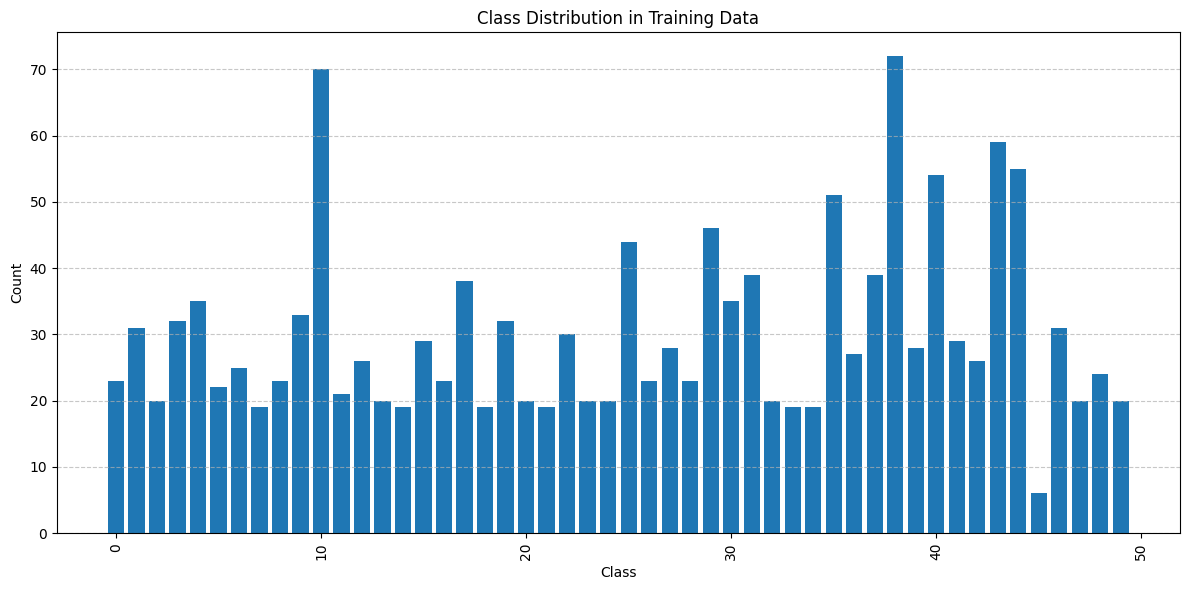

In [11]:
# Visualize class distribution
plt.figure(figsize=(12, 6))
class_counts = sorted(Counter(y_train).items())
classes, counts = zip(*class_counts)

plt.bar(classes, counts)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Distribution in Training Data')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [12]:
# Dimensionality reduction with PCA
print("\nPerforming initial dimensionality reduction...")
n_components = min(300, X_train.shape[0] // 4)
X_train_reduced, X_val_reduced, X_test_reduced = reduce_dimensionality_pca(
    X_train, X_val, X_test, n_components=n_components
)
print(f"Data after initial reduction: {X_train_reduced.shape}")



Performing initial dimensionality reduction...
Data after initial reduction: (1506, 300)


In [ ]:
# Standardize features
print("\nStandardizing features...")
(X_train_std, X_val_std, X_test_std), _ = standardize_features(
    X_train_reduced, X_val_reduced, X_test_reduced
)


Standardizing features...
Removing 0 low-variance features


In [ ]:
# Apply LDA
print("\nApplying LDA...")
n_components = min(50, len(np.unique(y_train))-1, X_train_std.shape[0] // 20)
lda = LDA(n_components=n_components)
lda.fit(X_train_std, y_train)

X_train_lda = lda.transform(X_train_std)
X_val_lda = lda.transform(X_val_std)
X_test_lda = lda.transform(X_test_std)



Applying LDA...
LDA explained variance: 1.0000


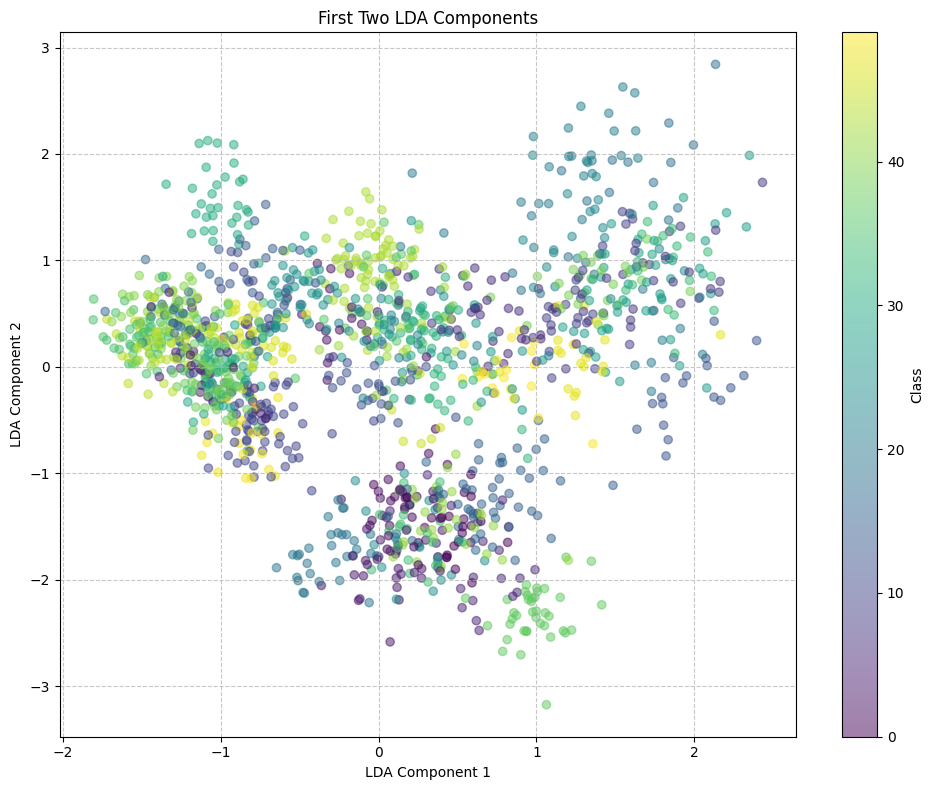

In [ ]:
# Visualize LDA components if possible
if X_train_lda.shape[1] >= 2:
    plt.figure(figsize=(10, 8))
    # Use first two components for visualization
    scatter = plt.scatter(X_train_lda[:, 0], X_train_lda[:, 1], c=y_train, 
                         alpha=0.5, cmap='viridis')
    plt.colorbar(scatter, label='Class')
    plt.xlabel('LDA Component 1')
    plt.ylabel('LDA Component 2')
    plt.title('First Two LDA Components')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


In [ ]:
# Simple feature engineering
print("\nApplying feature engineering...")
X_train_enhanced = np.hstack([
    X_train_lda,
    np.mean(X_train, axis=1, keepdims=True),
    np.std(X_train, axis=1, keepdims=True)
])
X_val_enhanced = np.hstack([
    X_val_lda,
    np.mean(X_val, axis=1, keepdims=True),
    np.std(X_val, axis=1, keepdims=True)
])
X_test_enhanced = np.hstack([
    X_test_lda,
    np.mean(X_test, axis=1, keepdims=True),
    np.std(X_test, axis=1, keepdims=True)
])
print(f"Enhanced features shape: {X_train_enhanced.shape}")



Applying feature engineering...
Enhanced features shape: (1506, 51)


In [ ]:
def adaboost_decision_trees_with_graph(X_train, y_train, X_val, y_val, X_test, y_test, n_estimators=20, max_depth=3):
    """AdaBoost ensemble method using Decision Trees from scratch with performance graph."""
    n_samples = X_train.shape[0]
    unique_classes = np.unique(y_train)
    
    # Convert labels to binary format for error calculation
    # For multi-class, we'll use one-vs-rest approach
    y_train_binary = {}
    for cls in unique_classes:
        y_train_binary[cls] = np.where(y_train == cls, 1, -1)
    
    # Initialize weights uniformly
    sample_weights = np.ones(n_samples) / n_samples
    
    estimators = []
    estimator_weights = []
    
    print("\nTesting AdaBoost on Decision Trees...")
    train_accuracies = []
    val_accuracies = []
    test_accuracies = []
    
    for i in range(n_estimators):
        # Train weak learner (shallow decision tree)
        tree = DecisionTree(max_depth=max_depth, criterion='entropy')
        tree.fit(X_train, y_train)
        
        # Get predictions
        predictions = tree.predict(X_train)
        
        # Calculate weighted error for each class
        class_errors = {}
        class_alphas = {}
        
        for cls in unique_classes:
            # Convert current predictions to binary for this class
            pred_binary = np.where(predictions == cls, 1, -1)
            
            # Calculate misclassification indicator
            incorrect = pred_binary != y_train_binary[cls]
            
            # Calculate weighted error
            error = np.sum(sample_weights * incorrect) / np.sum(sample_weights)
            
            # Ensure error is not 0 or 1 to avoid numerical issues
            error = max(1e-10, min(1 - 1e-10, error))
            
            # Calculate alpha (weight) for this class
            alpha = 0.5 * np.log((1 - error) / error)
            
            class_errors[cls] = error
            class_alphas[cls] = alpha
        
        # Use the average alpha across classes
        avg_alpha = np.mean(list(class_alphas.values()))
        
        # Store the model and its weight
        estimators.append(tree)
        estimator_weights.append(avg_alpha)
        
        # Update sample weights based on misclassifications
        for j in range(n_samples):
            if predictions[j] == y_train[j]:
                # Correctly classified - reduce weight
                sample_weights[j] *= np.exp(-avg_alpha)
            else:
                # Incorrectly classified - increase weight
                sample_weights[j] *= np.exp(avg_alpha)
        
        # Normalize weights
        sample_weights /= np.sum(sample_weights)
        
        # Aggregate predictions with weighted voting
        def weighted_predictions(X, estimators, estimator_weights):
            n_samples = X.shape[0]
            n_classes = len(unique_classes)
            
            # Initialize vote matrix (samples x classes)
            votes = np.zeros((n_samples, n_classes))
            
            # Collect weighted votes for each model
            for model, weight in zip(estimators, estimator_weights):
                model_preds = model.predict(X)
                
                # Add weighted votes for each prediction
                for i in range(n_samples):
                    class_idx = np.where(unique_classes == model_preds[i])[0][0]
                    votes[i, class_idx] += weight
            
            # Return class with highest weighted vote
            return unique_classes[np.argmax(votes, axis=1)]
        
        # Evaluate on training, validation, and testing data
        y_train_pred = weighted_predictions(X_train, estimators, estimator_weights)
        y_val_pred = weighted_predictions(X_val, estimators, estimator_weights)
        y_test_pred = weighted_predictions(X_test, estimators, estimator_weights)
        
        train_accuracy = accuracy(y_train, y_train_pred)
        val_accuracy = accuracy(y_val, y_val_pred)
        test_accuracy = accuracy(y_test, y_test_pred)
        
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        test_accuracies.append(test_accuracy)
        
        print(f"AdaBoost with {i + 1} estimators - Train Accuracy: {train_accuracy:.4f}, "
              f"Validation Accuracy: {val_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")
    
    # Plot performance graph
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, n_estimators + 1), train_accuracies, label='Training Accuracy', marker='o')
    plt.plot(range(1, n_estimators + 1), val_accuracies, label='Validation Accuracy', marker='^')
    plt.plot(range(1, n_estimators + 1), test_accuracies, label='Testing Accuracy', marker='s')
    plt.xlabel('Number of Estimators')
    plt.ylabel('Accuracy')
    plt.title('AdaBoost Performance')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    # Return final model details
    return estimators, estimator_weights, unique_classes, test_accuracies


In [ ]:
def improved_adaboost_decision_trees_with_graph(X_train, y_train, X_val, y_val, X_test, y_test, n_estimators=20, max_depth=3):
    """Improved AdaBoost ensemble method (SAMME algorithm) for multi-class classification."""
    n_samples = X_train.shape[0]
    unique_classes = np.unique(y_train)
    n_classes = len(unique_classes)
    
    # Initialize weights uniformly
    sample_weights = np.ones(n_samples) / n_samples
    
    estimators = []
    estimator_weights = []
    
    print("\nTesting Improved AdaBoost on Decision Trees...")
    train_accuracies = []
    val_accuracies = []
    test_accuracies = []
    test_predictions = None
    
    for i in range(n_estimators):
        # Create a copy of sample weights for this iteration
        current_weights = sample_weights.copy()
        
        # Train weak learner with sample weights
        tree = DecisionTree(max_depth=max_depth, criterion='entropy')
        
        # Pass weights to the tree by modifying the fit method behavior
        # We'll create weighted bootstrap samples
        bootstrap_indices = np.random.choice(
            n_samples, 
            size=n_samples, 
            replace=True, 
            p=current_weights/current_weights.sum()
        )
        X_bootstrap = X_train[bootstrap_indices]
        y_bootstrap = y_train[bootstrap_indices]
        
        # Fit on weighted bootstrap sample
        tree.fit(X_bootstrap, y_bootstrap)
        
        # Get predictions
        predictions = tree.predict(X_train)
        
        # Calculate weighted error
        incorrect = (predictions != y_train)
        weighted_error = np.sum(current_weights * incorrect) / np.sum(current_weights)
        
        # If error too large or too small, adjust tree and retry
        if weighted_error > 0.5 or weighted_error < 1e-10:
            # Try a different max_depth if error is too high
            retry_depth = max(1, max_depth - 1) if weighted_error > 0.5 else min(10, max_depth + 1)
            tree = DecisionTree(max_depth=retry_depth, criterion='entropy')
            tree.fit(X_bootstrap, y_bootstrap)
            predictions = tree.predict(X_train)
            incorrect = (predictions != y_train)
            weighted_error = np.sum(current_weights * incorrect) / np.sum(current_weights)
            
            # If still too high, make a very simple tree
            if weighted_error > 0.5:
                tree = DecisionTree(max_depth=1, criterion='entropy')
                tree.fit(X_bootstrap, y_bootstrap)
                predictions = tree.predict(X_train)
                incorrect = (predictions != y_train)
                weighted_error = np.sum(current_weights * incorrect) / np.sum(current_weights)
        
        # Ensure error is not 0 or 1 (numerical stability)
        weighted_error = max(1e-10, min(1 - 1e-10, weighted_error))
        
        # Calculate alpha (SAMME algorithm for multi-class)
        alpha = np.log((1 - weighted_error) / weighted_error) + np.log(n_classes - 1)
        alpha = max(0.0, alpha)  # Ensure non-negative weight
        
        # Store the model and its weight
        estimators.append(tree)
        estimator_weights.append(alpha)
        
        # Update sample weights
        sample_weights = sample_weights * np.exp(alpha * incorrect)
        
        # Normalize weights
        sample_weights = sample_weights / np.sum(sample_weights)
        
        # Weighted prediction function
        def samme_predict(X, estimators, estimator_weights):
            n_samples = X.shape[0]
            n_estimators = len(estimators)
            
            # Initialize scores: samples x classes
            scores = np.zeros((n_samples, n_classes))
            
            # For each estimator
            for estimator, weight in zip(estimators, estimator_weights):
                preds = estimator.predict(X)
                
                # One-hot encode predictions and weight them
                for i in range(n_samples):
                    class_idx = np.where(unique_classes == preds[i])[0][0]
                    scores[i, class_idx] += weight
            
            # Return class with highest score
            return unique_classes[np.argmax(scores, axis=1)]
        
        # Evaluate on training, validation, and testing data
        y_train_pred = samme_predict(X_train, estimators, estimator_weights)
        y_val_pred = samme_predict(X_val, estimators, estimator_weights)
        y_test_pred = samme_predict(X_test, estimators, estimator_weights)
        
        # Save the latest test predictions
        test_predictions = y_test_pred
        
        train_accuracy = accuracy(y_train, y_train_pred)
        val_accuracy = accuracy(y_val, y_val_pred)
        test_accuracy = accuracy(y_test, y_test_pred)
        
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        test_accuracies.append(test_accuracy)
        
        print(f"Improved AdaBoost with {i + 1} estimators - Train Accuracy: {train_accuracy:.4f}, "
              f"Validation Accuracy: {val_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")
    
    # Plot performance graph
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, n_estimators + 1), train_accuracies, label='Training Accuracy', marker='o')
    plt.plot(range(1, n_estimators + 1), val_accuracies, label='Validation Accuracy', marker='^')
    plt.plot(range(1, n_estimators + 1), test_accuracies, label='Testing Accuracy', marker='s')
    plt.xlabel('Number of Estimators')
    plt.ylabel('Accuracy')
    plt.title('Improved AdaBoost Performance')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    # Return final model details
    return estimators, estimator_weights, test_accuracies, test_predictions, unique_classes



--- AdaBoost Testing with Graph ---

Testing AdaBoost on Decision Trees...
AdaBoost with 1 estimators - Train Accuracy: 0.2078, Validation Accuracy: 0.1892, Test Accuracy: 0.1928
AdaBoost with 2 estimators - Train Accuracy: 0.2078, Validation Accuracy: 0.1892, Test Accuracy: 0.1928
AdaBoost with 3 estimators - Train Accuracy: 0.2078, Validation Accuracy: 0.1892, Test Accuracy: 0.1928
AdaBoost with 4 estimators - Train Accuracy: 0.2078, Validation Accuracy: 0.1892, Test Accuracy: 0.1928
AdaBoost with 5 estimators - Train Accuracy: 0.2078, Validation Accuracy: 0.1892, Test Accuracy: 0.1928
AdaBoost with 6 estimators - Train Accuracy: 0.2078, Validation Accuracy: 0.1892, Test Accuracy: 0.1928
AdaBoost with 7 estimators - Train Accuracy: 0.2078, Validation Accuracy: 0.1892, Test Accuracy: 0.1928
AdaBoost with 8 estimators - Train Accuracy: 0.2078, Validation Accuracy: 0.1892, Test Accuracy: 0.1928
AdaBoost with 9 estimators - Train Accuracy: 0.2078, Validation Accuracy: 0.1892, Test Accur

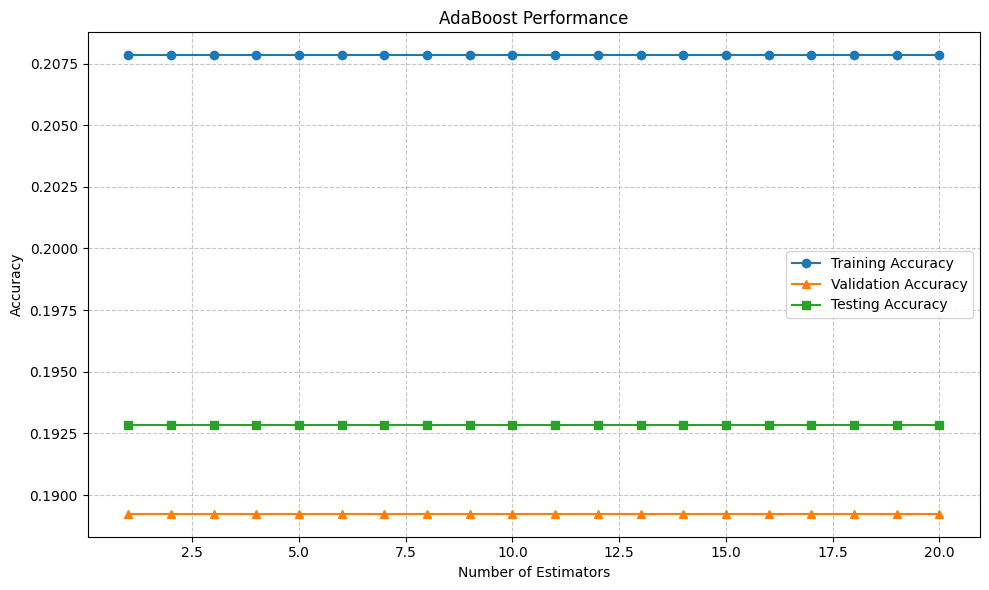

In [ ]:
# Add the AdaBoost method testing
print("\n--- AdaBoost Testing with Graph ---")
adaboost_estimators, adaboost_weights, adaboost_classes,adaboost_accuracies = adaboost_decision_trees_with_graph(
    X_train_enhanced, y_train, X_val_enhanced, y_val, X_test_enhanced, y_test, n_estimators=20, max_depth=3
)



--- Improved AdaBoost Testing with Graph ---

Testing Improved AdaBoost on Decision Trees...
Improved AdaBoost with 1 estimators - Train Accuracy: 0.0737, Validation Accuracy: 0.0737, Test Accuracy: 0.0736
Improved AdaBoost with 2 estimators - Train Accuracy: 0.0717, Validation Accuracy: 0.0677, Test Accuracy: 0.0696
Improved AdaBoost with 3 estimators - Train Accuracy: 0.0717, Validation Accuracy: 0.0677, Test Accuracy: 0.0696
Improved AdaBoost with 4 estimators - Train Accuracy: 0.0717, Validation Accuracy: 0.0677, Test Accuracy: 0.0696
Improved AdaBoost with 5 estimators - Train Accuracy: 0.0717, Validation Accuracy: 0.0677, Test Accuracy: 0.0696
Improved AdaBoost with 6 estimators - Train Accuracy: 0.0717, Validation Accuracy: 0.0677, Test Accuracy: 0.0696
Improved AdaBoost with 7 estimators - Train Accuracy: 0.0717, Validation Accuracy: 0.0677, Test Accuracy: 0.0696
Improved AdaBoost with 8 estimators - Train Accuracy: 0.0717, Validation Accuracy: 0.0677, Test Accuracy: 0.0696
Im

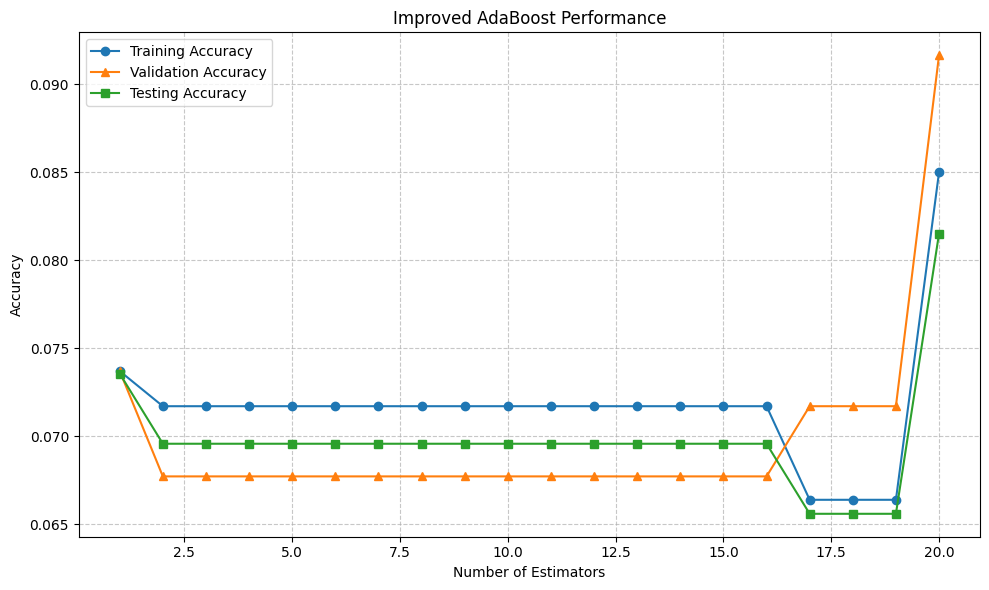

In [ ]:
# Add the Improved AdaBoost method testing
print("\n--- Improved AdaBoost Testing with Graph ---")
improved_adaboost_estimators, improved_adaboost_weights, improved_adaboost_accuracies, improved_adaboost_predictions, improved_adaboost_classes = improved_adaboost_decision_trees_with_graph(
    X_train_enhanced, y_train, X_val_enhanced, y_val, X_test_enhanced, y_test, n_estimators=20, max_depth=3
)



--- Running Bagging for Comparison ---

Testing Bagging on Decision Trees...
Bagging with 1 estimators - Train Accuracy: 0.8559, Validation Accuracy: 0.5279, Test Accuracy: 0.5626
Bagging with 2 estimators - Train Accuracy: 0.8559, Validation Accuracy: 0.5279, Test Accuracy: 0.5626
Bagging with 3 estimators - Train Accuracy: 0.9456, Validation Accuracy: 0.6195, Test Accuracy: 0.6561
Bagging with 4 estimators - Train Accuracy: 0.9555, Validation Accuracy: 0.6813, Test Accuracy: 0.7117
Bagging with 5 estimators - Train Accuracy: 0.9741, Validation Accuracy: 0.6972, Test Accuracy: 0.7316
Bagging with 6 estimators - Train Accuracy: 0.9821, Validation Accuracy: 0.6932, Test Accuracy: 0.7416
Bagging with 7 estimators - Train Accuracy: 0.9854, Validation Accuracy: 0.7131, Test Accuracy: 0.7575
Bagging with 8 estimators - Train Accuracy: 0.9907, Validation Accuracy: 0.7390, Test Accuracy: 0.7654
Bagging with 9 estimators - Train Accuracy: 0.9927, Validation Accuracy: 0.7450, Test Accuracy: 0.

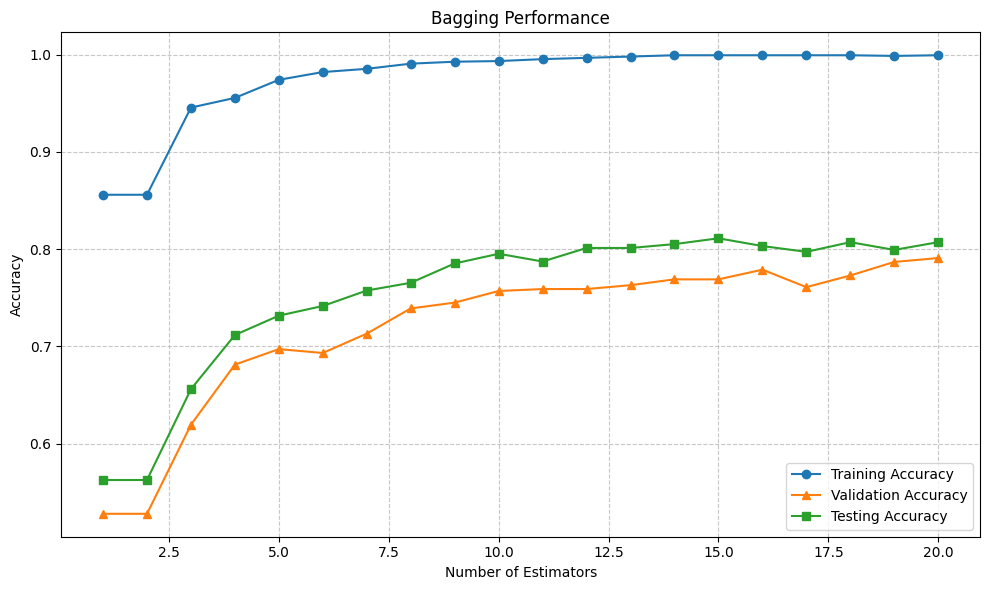

In [ ]:
# Run bagging one time to get accuracies for comparison
print("\n--- Running Bagging for Comparison ---")
_, _, bagging_accuracies = bagging_decision_trees_with_graph(
    X_train_enhanced, y_train, X_val_enhanced, y_val, X_test_enhanced, y_test, n_estimators=20
)

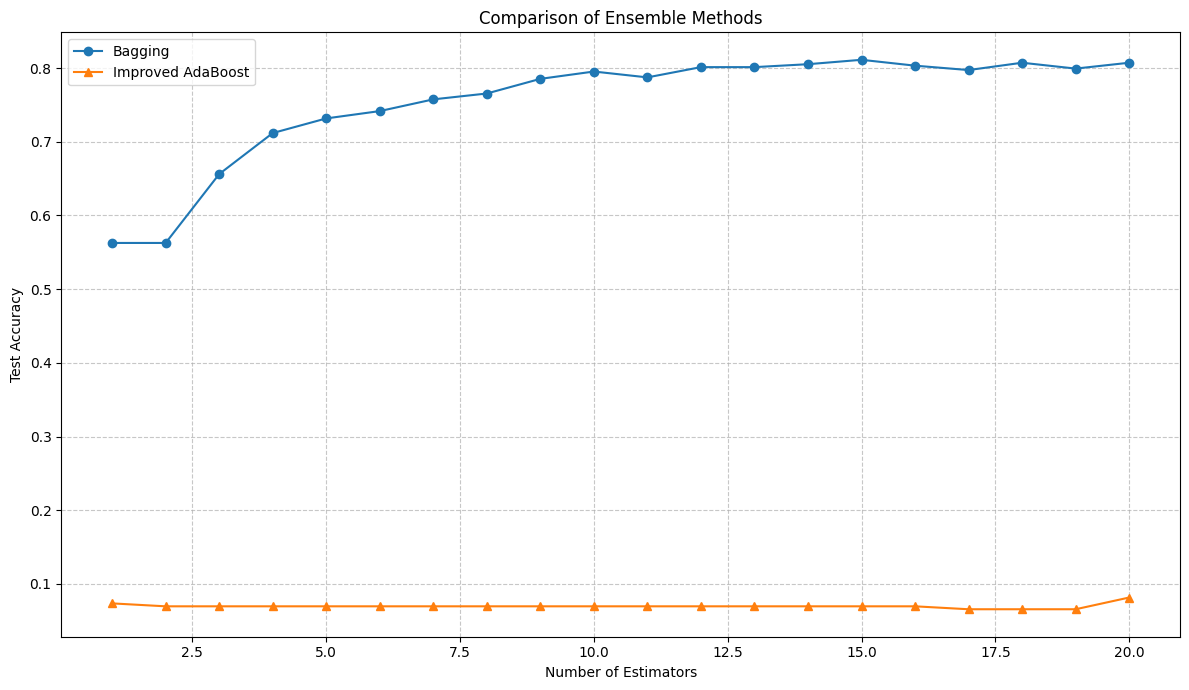

In [ ]:
# Compare all methods in a single graph using pre-computed accuracies
plt.figure(figsize=(12, 7))
plt.plot(range(1, len(bagging_accuracies)+1), bagging_accuracies, label='Bagging', marker='o')
plt.plot(range(1, len(improved_adaboost_accuracies)+1), improved_adaboost_accuracies, label='Improved AdaBoost', marker='^')
plt.xlabel('Number of Estimators')
plt.ylabel('Test Accuracy')
plt.title('Comparison of Ensemble Methods')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
def gradient_boosting_with_graph(X_train, y_train, X_val, y_val, X_test, y_test, n_estimators=20, max_depth=3, learning_rate=0.1):
    """Gradient Boosting ensemble method using Decision Trees from scratch with performance graph."""
    n_samples = X_train.shape[0]
    unique_classes = np.unique(y_train)
    n_classes = len(unique_classes)
    
    # Initialize performance tracking
    print("\nTesting Gradient Boosting on Decision Trees...")
    train_accuracies = []
    val_accuracies = []
    test_accuracies = []
    test_predictions = None
    
    # For multi-class classification, we'll use one-vs-rest approach with separate trees for each class
    # Initialize models for each class
    class_estimators = {cls: [] for cls in unique_classes}
    
    # Create initial predictions (log-odds) - start with zeros
    # Shape: samples x classes
    F_train = np.zeros((X_train.shape[0], n_classes))
    F_val = np.zeros((X_val.shape[0], n_classes))
    F_test = np.zeros((X_test.shape[0], n_classes))
    
    # One-hot encode the target variable
    y_one_hot = np.zeros((n_samples, n_classes))
    for i, cls in enumerate(unique_classes):
        y_one_hot[y_train == cls, i] = 1
    
    # Helper function to compute softmax probabilities
    def softmax(x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))  # Subtract max for numerical stability
        return exp_x / np.sum(exp_x, axis=1, keepdims=True)
    
    # Helper function to make predictions
    def predict_proba(F):
        return softmax(F)
    
    def predict(F):
        return unique_classes[np.argmax(F, axis=1)]
    
    # Start boosting iterations
    for i in range(n_estimators):
        # Current predictions (probabilities via softmax)
        p_train = predict_proba(F_train)
        
        # For each class, compute gradients and fit trees
        for j, cls in enumerate(unique_classes):
            # Compute negative gradients (residuals) for current class
            # For softmax with cross-entropy loss: gradient = p_k - y_k (predicted prob - actual)
            residuals = p_train[:, j] - y_one_hot[:, j]
            
            # Fit a tree to the negative gradients
            tree = DecisionTree(max_depth=max_depth, criterion='entropy')
            tree.fit(X_train, residuals)
            
            # Make predictions with the tree
            train_preds = tree.predict(X_train)
            val_preds = tree.predict(X_val)
            test_preds = tree.predict(X_test)
            
            # Update the models for this class
            class_estimators[cls].append(tree)
            
            # Update F (adding negative gradients because we want to minimize loss)
            F_train[:, j] -= learning_rate * train_preds
            F_val[:, j] -= learning_rate * val_preds
            F_test[:, j] -= learning_rate * test_preds
        
        # Calculate current accuracy after this iteration
        y_train_pred = predict(F_train)
        y_val_pred = predict(F_val)
        y_test_pred = predict(F_test)
        
        # Save the latest test predictions
        test_predictions = y_test_pred
        
        train_accuracy = accuracy(y_train, y_train_pred)
        val_accuracy = accuracy(y_val, y_val_pred)
        test_accuracy = accuracy(y_test, y_test_pred)
        
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        test_accuracies.append(test_accuracy)
        
        print(f"Gradient Boosting with {i + 1} iterations - Train Accuracy: {train_accuracy:.4f}, "
              f"Validation Accuracy: {val_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")
    
    # Plot performance graph
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, n_estimators + 1), train_accuracies, label='Training Accuracy', marker='o')
    plt.plot(range(1, n_estimators + 1), val_accuracies, label='Validation Accuracy', marker='^')
    plt.plot(range(1, n_estimators + 1), test_accuracies, label='Testing Accuracy', marker='s')
    plt.xlabel('Number of Iterations')
    plt.ylabel('Accuracy')
    plt.title('Gradient Boosting Performance')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    return class_estimators, test_accuracies, test_predictions, unique_classes



--- Running Gradient Boosting for Comparison ---

Testing Gradient Boosting on Decision Trees...
Gradient Boosting with 1 iterations - Train Accuracy: 0.1408, Validation Accuracy: 0.1255, Test Accuracy: 0.1312
Gradient Boosting with 2 iterations - Train Accuracy: 0.1401, Validation Accuracy: 0.1215, Test Accuracy: 0.1312
Gradient Boosting with 3 iterations - Train Accuracy: 0.1401, Validation Accuracy: 0.1215, Test Accuracy: 0.1272
Gradient Boosting with 4 iterations - Train Accuracy: 0.1521, Validation Accuracy: 0.1355, Test Accuracy: 0.1372
Gradient Boosting with 5 iterations - Train Accuracy: 0.1494, Validation Accuracy: 0.1295, Test Accuracy: 0.1372
Gradient Boosting with 6 iterations - Train Accuracy: 0.1487, Validation Accuracy: 0.1295, Test Accuracy: 0.1372
Gradient Boosting with 7 iterations - Train Accuracy: 0.1494, Validation Accuracy: 0.1295, Test Accuracy: 0.1372
Gradient Boosting with 8 iterations - Train Accuracy: 0.1487, Validation Accuracy: 0.1295, Test Accuracy: 0.137

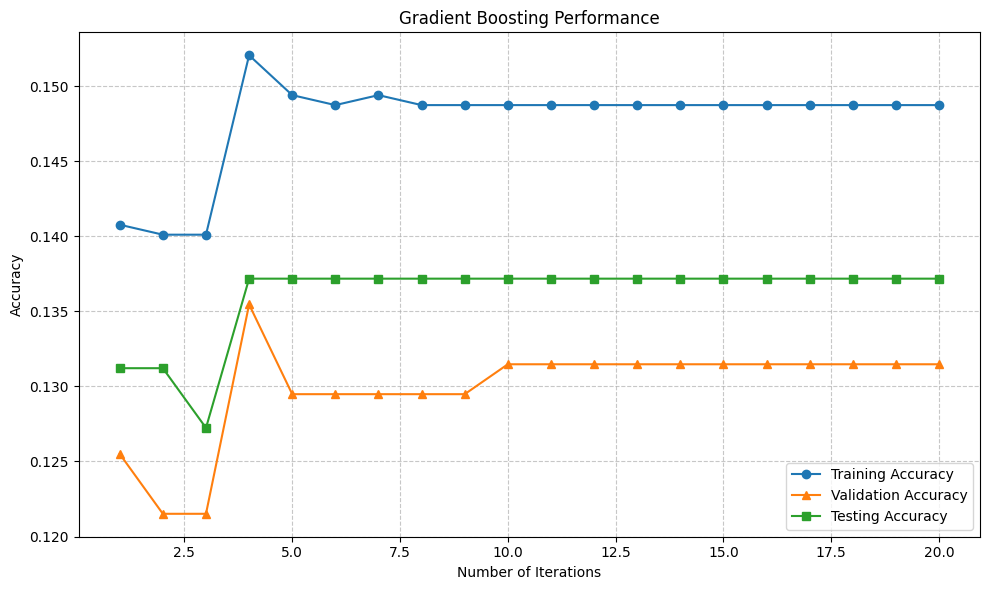

In [ ]:
# Run gradient boosting for comparison
print("\n--- Running Gradient Boosting for Comparison ---")
_, gradient_boosting_accuracies, gradient_boosting_predictions, _ = gradient_boosting_with_graph(
    X_train_enhanced, y_train, X_val_enhanced, y_val, X_test_enhanced, y_test, n_estimators=20, max_depth=3, learning_rate=0.1
)

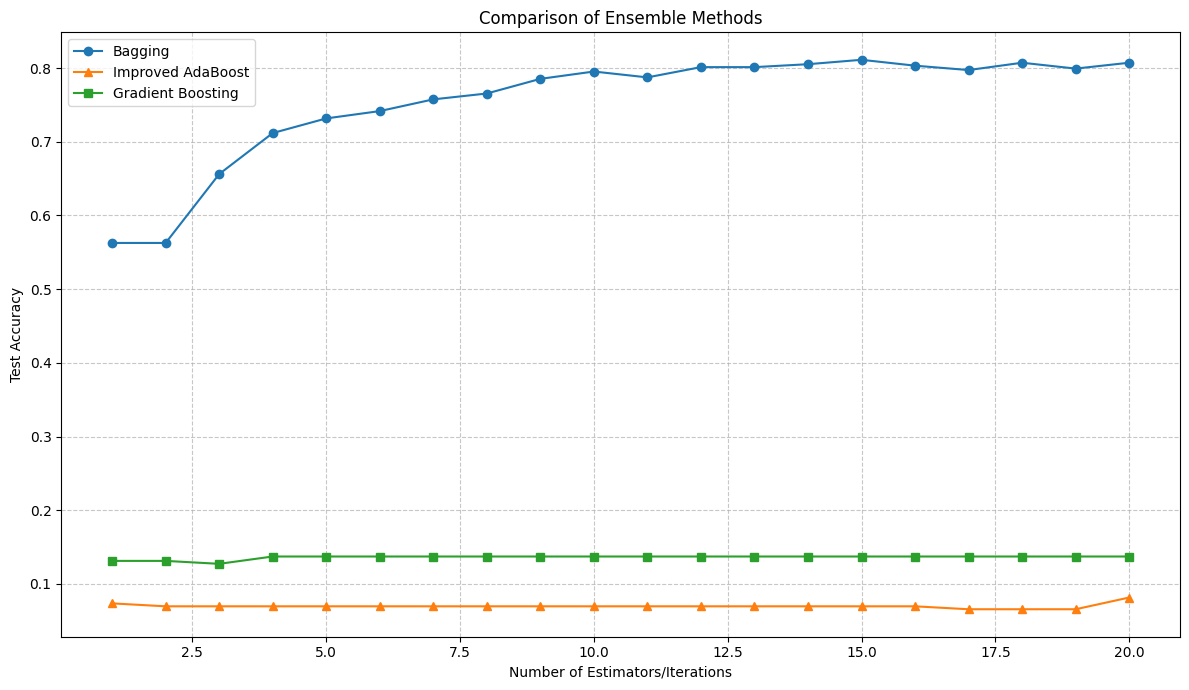

In [ ]:
# Compare all methods in a single graph using pre-computed accuracies
plt.figure(figsize=(12, 7))
plt.plot(range(1, len(bagging_accuracies)+1), bagging_accuracies, label='Bagging', marker='o')
plt.plot(range(1, len(improved_adaboost_accuracies)+1), improved_adaboost_accuracies, label='Improved AdaBoost', marker='^')
plt.plot(range(1, len(gradient_boosting_accuracies)+1), gradient_boosting_accuracies, label='Gradient Boosting', marker='s')
plt.xlabel('Number of Estimators/Iterations')
plt.ylabel('Test Accuracy')
plt.title('Comparison of Ensemble Methods')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
# Implement SVM from scratch
class SVM:
    def __init__(self, learning_rate=0.01, lambda_param=0.01, n_iters=1000):
        self.lr = learning_rate
        self.lambda_param = lambda_param
        self.n_iters = n_iters
        self.weights = None
        self.bias = None
        
    def fit(self, X, y):
        n_samples, n_features = X.shape
        
        # For multi-class, we'll train one model per class (one-vs-rest)
        self.classes = np.unique(y)
        self.models = {}
        
        for cls in self.classes:
            # Convert to binary problem
            y_binary = np.where(y == cls, 1, -1)
            
            # Initialize weights and bias
            w = np.zeros(n_features)
            b = 0
            
            # Gradient descent
            for _ in range(self.n_iters):
                for idx, x_i in enumerate(X):
                    condition = y_binary[idx] * (np.dot(x_i, w) - b) >= 1
                    if condition:
                        w = w - self.lr * (2 * self.lambda_param * w)
                    else:
                        w = w - self.lr * (2 * self.lambda_param * w - np.dot(x_i, y_binary[idx]))
                        b = b - self.lr * y_binary[idx]
            
            self.models[cls] = (w, b)
        
        return self
    
    def predict(self, X):
        n_samples = X.shape[0]
        y_pred = np.zeros(n_samples)
        
        # Calculate decision values for each class
        scores = np.zeros((n_samples, len(self.classes)))
        
        for i, cls in enumerate(self.classes):
            w, b = self.models[cls]
            scores[:, i] = np.dot(X, w) - b
        
        # Assign the class with highest score
        y_pred = self.classes[np.argmax(scores, axis=1)]
        return y_pred


In [ ]:
# Implement GMM from scratch
class GMM:
    def __init__(self, n_components=3, max_iters=100, tol=1e-3):
        self.n_components = n_components
        self.max_iters = max_iters
        self.tol = tol
        self.models = {}
        self.classes = None
        
    def _initialize_parameters(self, X):
        n_samples, n_features = X.shape
        
        # Initialize means randomly from data points
        idx = np.random.choice(n_samples, self.n_components, replace=False)
        means = X[idx]
        
        # Initialize covariances as identity matrices
        covariances = np.array([np.eye(n_features) for _ in range(self.n_components)])
        
        # Initialize weights uniformly
        weights = np.ones(self.n_components) / self.n_components
        
        return means, covariances, weights
    
    def _expectation(self, X, means, covariances, weights):
        n_samples = X.shape[0]
        
        # Calculate responsibilities (gamma)
        gamma = np.zeros((n_samples, self.n_components))
        
        for k in range(self.n_components):
            # Calculate multivariate normal density
            covar = covariances[k]
            try:
                covar_inv = np.linalg.inv(covar)
                covar_det = np.linalg.det(covar)
                
                if covar_det <= 0:
                    covar = covar + np.eye(covar.shape[0]) * 1e-6
                    covar_inv = np.linalg.inv(covar)
                    covar_det = np.linalg.det(covar)
            except:
                # Add regularization if matrix is singular
                covar = covar + np.eye(covar.shape[0]) * 1e-3
                covar_inv = np.linalg.inv(covar)
                covar_det = np.linalg.det(covar)
            
            diff = X - means[k]
            exponent = -0.5 * np.sum(diff @ covar_inv * diff, axis=1)
            norm_const = 1.0 / np.sqrt((2 * np.pi) ** X.shape[1] * covar_det)
            
            gamma[:, k] = weights[k] * norm_const * np.exp(exponent)
        
        # Normalize responsibilities
        gamma_sum = gamma.sum(axis=1, keepdims=True)
        gamma_sum[gamma_sum == 0] = 1e-10  # Avoid division by zero
        gamma = gamma / gamma_sum
        
        return gamma
    
    def _maximization(self, X, gamma):
        n_samples = X.shape[0]
        
        # Calculate effective number of points assigned to each component
        N_k = gamma.sum(axis=0)
        N_k[N_k == 0] = 1e-10  # Avoid division by zero
        
        # Update means
        means = np.dot(gamma.T, X) / N_k[:, np.newaxis]
        
        # Update covariances
        covariances = np.zeros((self.n_components, X.shape[1], X.shape[1]))
        for k in range(self.n_components):
            diff = X - means[k]
            covariances[k] = (gamma[:, k, np.newaxis] * diff).T @ diff / N_k[k]
            
            # Add regularization
            covariances[k] += np.eye(X.shape[1]) * 1e-6
        
        # Update weights
        weights = N_k / n_samples
        
        return means, covariances, weights
    
    def _compute_log_likelihood(self, X, means, covariances, weights):
        n_samples = X.shape[0]
        log_likelihood = 0
        
        for i in range(n_samples):
            sample_likelihood = 0
            for k in range(self.n_components):
                # Calculate multivariate normal density
                covar = covariances[k]
                try:
                    covar_inv = np.linalg.inv(covar)
                    covar_det = np.linalg.det(covar)
                except:
                    # Add regularization if matrix is singular
                    covar = covar + np.eye(covar.shape[0]) * 1e-3
                    covar_inv = np.linalg.inv(covar)
                    covar_det = np.linalg.det(covar)
                
                diff = X[i] - means[k]
                exponent = -0.5 * np.dot(np.dot(diff, covar_inv), diff)
                norm_const = 1.0 / np.sqrt((2 * np.pi) ** X.shape[1] * covar_det)
                
                sample_likelihood += weights[k] * norm_const * np.exp(exponent)
            
            log_likelihood += np.log(sample_likelihood + 1e-10)
        
        return log_likelihood
    
    def _fit_single_class(self, X):
        # Initialize parameters
        means, covariances, weights = self._initialize_parameters(X)
        
        # EM algorithm
        log_likelihood_old = 0
        for iteration in range(self.max_iters):
            # E-step
            gamma = self._expectation(X, means, covariances, weights)
            
            # M-step
            means, covariances, weights = self._maximization(X, gamma)
            
            # Compute log-likelihood
            log_likelihood = self._compute_log_likelihood(X, means, covariances, weights)
            
            # Check convergence
            if abs(log_likelihood - log_likelihood_old) < self.tol:
                break
                
            log_likelihood_old = log_likelihood
        
        return means, covariances, weights
    
    def fit(self, X, y):
        self.classes = np.unique(y)
        
        # Fit a GMM for each class
        for cls in self.classes:
            X_cls = X[y == cls]
            means, covariances, weights = self._fit_single_class(X_cls)
            self.models[cls] = (means, covariances, weights)
        
        return self
    
    def _class_likelihood(self, X, cls):
        means, covariances, weights = self.models[cls]
        n_samples = X.shape[0]
        
        # Calculate likelihood for each sample
        likelihoods = np.zeros(n_samples)
        
        for i in range(n_samples):
            sample_likelihood = 0
            for k in range(self.n_components):
                # Calculate multivariate normal density
                covar = covariances[k]
                try:
                    covar_inv = np.linalg.inv(covar)
                    covar_det = np.linalg.det(covar)
                    
                    if covar_det <= 0:
                        covar = covar + np.eye(covar.shape[0]) * 1e-6
                        covar_inv = np.linalg.inv(covar)
                        covar_det = np.linalg.det(covar)
                except:
                    # Add regularization if matrix is singular
                    covar = covar + np.eye(covar.shape[0]) * 1e-3
                    covar_inv = np.linalg.inv(covar)
                    covar_det = np.linalg.det(covar)
                
                diff = X[i] - means[k]
                exponent = -0.5 * np.dot(np.dot(diff, covar_inv), diff)
                norm_const = 1.0 / np.sqrt((2 * np.pi) ** X.shape[1] * covar_det)
                
                sample_likelihood += weights[k] * norm_const * np.exp(exponent)
            
            likelihoods[i] = sample_likelihood
        
        return likelihoods
    
    def predict(self, X):
        n_samples = X.shape[0]
        
        # Calculate likelihood for each class
        likelihoods = np.zeros((n_samples, len(self.classes)))
        
        for i, cls in enumerate(self.classes):
            likelihoods[:, i] = self._class_likelihood(X, cls)
        
        # Return class with highest likelihood
        return self.classes[np.argmax(likelihoods, axis=1)]



In [ ]:
# Implement Random Forest from scratch
class RandomForest:
    def __init__(self, n_estimators=10, max_depth=None, min_samples_split=2, 
                 min_samples_leaf=1, max_features='sqrt', bootstrap=True):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.min_samples_leaf = min_samples_leaf
        self.max_features = max_features
        self.bootstrap = bootstrap
        self.trees = []
        
    def fit(self, X, y):
        n_samples, n_features = X.shape
        
        # Determine max_features
        if self.max_features == 'sqrt':
            self.max_features_value = int(np.sqrt(n_features))
        elif self.max_features == 'log2':
            self.max_features_value = int(np.log2(n_features))
        elif isinstance(self.max_features, int):
            self.max_features_value = self.max_features
        elif isinstance(self.max_features, float):
            self.max_features_value = int(self.max_features * n_features)
        else:
            self.max_features_value = n_features
            
        self.max_features_value = max(1, min(n_features, self.max_features_value))
        
        # Train each tree
        for _ in range(self.n_estimators):
            # Bootstrap sampling
            if self.bootstrap:
                idx = np.random.choice(n_samples, n_samples, replace=True)
                X_sample, y_sample = X[idx], y[idx]
            else:
                X_sample, y_sample = X, y
                
            # Create and train tree with random feature selection
            tree = RandomDecisionTree(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                min_samples_leaf=self.min_samples_leaf,
                max_features=self.max_features_value
            )
            tree.fit(X_sample, y_sample)
            self.trees.append(tree)
            
        return self
    
    def predict(self, X):
        # Get predictions from each tree
        tree_preds = np.array([tree.predict(X) for tree in self.trees])
        
        # Return majority vote
        return np.apply_along_axis(lambda x: Counter(x).most_common(1)[0][0], axis=0, arr=tree_preds)

class RandomDecisionTree(DecisionTree):
    def __init__(self, max_depth=None, min_samples_split=2, min_samples_leaf=1, 
                 criterion='entropy', class_weight=None, max_features=None):
        super().__init__(max_depth, min_samples_split, min_samples_leaf, criterion, class_weight)
        self.max_features = max_features
        
    def _best_split(self, X, y, sample_weights):
        best_gain = 0
        best_feature = None
        best_threshold = None
        n_features = X.shape[1]

        # Calculate base impurity
        if self.criterion == 'entropy':
            base_impurity = self._weighted_entropy(y, sample_weights)
        else:  # 'gini'
            base_impurity = self._weighted_gini(y, sample_weights)
            
        # Randomly select subset of features to consider
        feature_indices = np.random.choice(n_features, 
                                          size=self.max_features, 
                                          replace=False)

        # Try each selected feature
        for feature_idx in feature_indices:
            feature_values = X[:, feature_idx]

            # Skip features with insufficient valid values
            valid_indices = np.isfinite(feature_values)
            if np.sum(valid_indices) <= 1:
                continue

            valid_values = feature_values[valid_indices]
            unique_values = np.unique(valid_values)

            # Skip features with only one unique value
            if len(unique_values) <= 1:
                continue

            # Determine thresholds to try
            if len(unique_values) > 10:
                percentiles = np.linspace(10, 90, 10)
                thresholds = np.percentile(valid_values, percentiles)
            else:
                thresholds = (unique_values[:-1] + unique_values[1:]) / 2

            # Try each threshold
            for threshold in thresholds:
                # Split data
                left_indices = feature_values < threshold
                right_indices = ~left_indices

                # Skip if split doesn't meet minimum leaf requirements
                if np.sum(left_indices) < self.min_samples_leaf or np.sum(right_indices) < self.min_samples_leaf:
                    continue

                # Calculate weighted information gain
                left_weights = sample_weights[left_indices]
                right_weights = sample_weights[right_indices]

                # Calculate impurities
                if self.criterion == 'entropy':
                    left_impurity = self._weighted_entropy(y[left_indices], left_weights)
                    right_impurity = self._weighted_entropy(y[right_indices], right_weights)
                else:  # 'gini'
                    left_impurity = self._weighted_gini(y[left_indices], left_weights)
                    right_impurity = self._weighted_gini(y[right_indices], right_weights)

                # Weighted sum of child impurities
                left_weight = np.sum(left_weights) / np.sum(sample_weights)
                right_weight = np.sum(right_weights) / np.sum(sample_weights)

                weighted_impurity = (left_weight * left_impurity) + (right_weight * right_impurity)
                information_gain = base_impurity - weighted_impurity

                # Balance penalty (avoid extremely imbalanced splits)
                balance_penalty = 1.0 - abs(left_weight - right_weight)
                adjusted_gain = information_gain * balance_penalty

                # Update best split if better
                if adjusted_gain > best_gain:
                    best_gain = adjusted_gain
                    best_feature = feature_idx
                    best_threshold = threshold

        return best_feature, best_threshold, best_gain


In [ ]:
def stacked_ensemble_with_graph(X_train, y_train, X_val, y_val, X_test, y_test, 
                               n_estimators_rf=10, max_depth_rf=5, n_components_gmm=3):
    """
    Implements a stacked ensemble using SVM, GMM, and Random Forest as base learners.
    
    Args:
        X_train, y_train: Training data
        X_val, y_val: Validation data for meta-learner training
        X_test, y_test: Test data
        n_estimators_rf: Number of trees in Random Forest
        max_depth_rf: Max depth for Random Forest trees
        n_components_gmm: Number of components in GMM
    
    Returns:
        Final model, train/val/test accuracies, and test predictions
    """
    print("\nTraining Stacked Ensemble (SVM + GMM + Random Forest)...")
    
    # Define reduced feature counts for different models
    # Depending on the dimensionality, we may need to use different feature counts
    n_samples, n_features = X_train.shape
    gmm_features = min(10, n_features)  # GMM works better with fewer features
    
    # Prepare the base learners
    print("\nTraining base learners...")
    
    # Train SVM
    print("Training SVM...")
    svm = SVM(learning_rate=0.01, lambda_param=0.01, n_iters=500)
    svm.fit(X_train, y_train)
    
    # Train GMM with PCA reduction first to handle high dimensions
    print("Training GMM...")
    X_train_gmm, X_val_gmm, X_test_gmm = reduce_dimensionality_pca(
        X_train, X_val, X_test, n_components=gmm_features
    )
    gmm = GMM(n_components=n_components_gmm, max_iters=50)
    gmm.fit(X_train_gmm, y_train)
    
    # Train Random Forest
    print("Training Random Forest...")
    random_forest = RandomForest(
        n_estimators=n_estimators_rf, 
        max_depth=max_depth_rf,
        max_features='sqrt',
        bootstrap=True
    )
    random_forest.fit(X_train, y_train)
    
    # Generate predictions from base learners on all datasets
    print("\nGenerating meta-features...")
    svm_train_pred = svm.predict(X_train)
    svm_val_pred = svm.predict(X_val)
    svm_test_pred = svm.predict(X_test)
    
    gmm_train_pred = gmm.predict(X_train_gmm)
    gmm_val_pred = gmm.predict(X_val_gmm)
    gmm_test_pred = gmm.predict(X_test_gmm)
    
    # Create meta-features for validation set
    meta_X_val = np.column_stack([
        svm_val_pred,
        gmm_val_pred,
        random_forest.predict(X_val)
    ])
    
    # Train meta-learner on validation predictions
    print("\nTraining meta-learner...")
    meta_learner = DecisionTree(max_depth=5, criterion='entropy')
    meta_learner.fit(meta_X_val, y_val)
    
    # Track performance over iterations
    train_accuracies = []
    val_accuracies = []
    test_accuracies = []
    
    # For the RF, we'll simulate iterative addition of trees
    for i in range(1, n_estimators_rf + 1):
        # Use subset of trees
        subset_rf = RandomForest(n_estimators=i, max_depth=max_depth_rf)
        subset_rf.trees = random_forest.trees[:i]
        
        # Get predictions for all datasets
        rf_train_pred = subset_rf.predict(X_train)
        rf_val_pred = subset_rf.predict(X_val)
        rf_test_pred = subset_rf.predict(X_test)
        
        # Create meta-features for all datasets
        meta_X_train = np.column_stack([svm_train_pred, gmm_train_pred, rf_train_pred])
        meta_X_val = np.column_stack([svm_val_pred, gmm_val_pred, rf_val_pred])
        meta_X_test = np.column_stack([svm_test_pred, gmm_test_pred, rf_test_pred])
        
        # Generate final predictions
        train_pred = meta_learner.predict(meta_X_train)
        val_pred = meta_learner.predict(meta_X_val)
        test_pred = meta_learner.predict(meta_X_test)
        
        # Calculate accuracies
        train_accuracy = accuracy(y_train, train_pred)
        val_accuracy = accuracy(y_val, val_pred)
        test_accuracy = accuracy(y_test, test_pred)
        
        # Store accuracies
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        test_accuracies.append(test_accuracy)
        
        print(f"Stacked Ensemble with {i} RF trees - Train accuracy: {train_accuracy:.4f}, "
              f"Val accuracy: {val_accuracy:.4f}, Test accuracy: {test_accuracy:.4f}")
    
    # Plot performance graph showing all three accuracies
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, n_estimators_rf + 1), train_accuracies, label='Training Accuracy', marker='o')
    plt.plot(range(1, n_estimators_rf + 1), val_accuracies, label='Validation Accuracy', marker='^')
    plt.plot(range(1, n_estimators_rf + 1), test_accuracies, label='Testing Accuracy', marker='s')
    plt.xlabel('Number of Trees in Random Forest Component')
    plt.ylabel('Accuracy')
    plt.title('Stacked Ensemble Performance (SVM + GMM + Random Forest)')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    # Create a separate plot focusing on training vs. validation (learning curve)
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, n_estimators_rf + 1), train_accuracies, label='Training Accuracy', marker='o', color='blue')
    plt.plot(range(1, n_estimators_rf + 1), val_accuracies, label='Validation Accuracy', marker='^', color='red')
    plt.fill_between(range(1, n_estimators_rf + 1), train_accuracies, val_accuracies, color='lightgray', alpha=0.5,
                     label='Generalization Gap')
    plt.xlabel('Number of Trees in Random Forest Component')
    plt.ylabel('Accuracy')
    plt.title('Stacked Ensemble Learning Curve')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    # Return the final model components and accuracy data
    model = {
        'svm': svm,
        'gmm': gmm,
        'random_forest': random_forest,
        'meta_learner': meta_learner,
        'gmm_features': gmm_features
    }
    
    # Get the final predictions using all trees
    rf_test_pred = random_forest.predict(X_test)
    meta_X_test = np.column_stack([svm_test_pred, gmm_test_pred, rf_test_pred])
    final_pred = meta_learner.predict(meta_X_test)
    
    return model, train_accuracies, val_accuracies, test_accuracies, final_pred



--- Running Stacked Ensemble (SVM + GMM + Random Forest) ---

Training Stacked Ensemble (SVM + GMM + Random Forest)...

Training base learners...
Training SVM...
Training GMM...
Training Random Forest...

Generating meta-features...

Training meta-learner...
Stacked Ensemble with 1 RF trees - Train accuracy: 0.2065, Val accuracy: 0.1474, Test accuracy: 0.1571
Stacked Ensemble with 2 RF trees - Train accuracy: 0.2065, Val accuracy: 0.1474, Test accuracy: 0.1571
Stacked Ensemble with 3 RF trees - Train accuracy: 0.2085, Val accuracy: 0.1614, Test accuracy: 0.1610
Stacked Ensemble with 4 RF trees - Train accuracy: 0.2503, Val accuracy: 0.1892, Test accuracy: 0.1829
Stacked Ensemble with 5 RF trees - Train accuracy: 0.2981, Val accuracy: 0.2171, Test accuracy: 0.2107
Stacked Ensemble with 6 RF trees - Train accuracy: 0.3167, Val accuracy: 0.2351, Test accuracy: 0.2445
Stacked Ensemble with 7 RF trees - Train accuracy: 0.3307, Val accuracy: 0.2510, Test accuracy: 0.2485
Stacked Ensemble wi

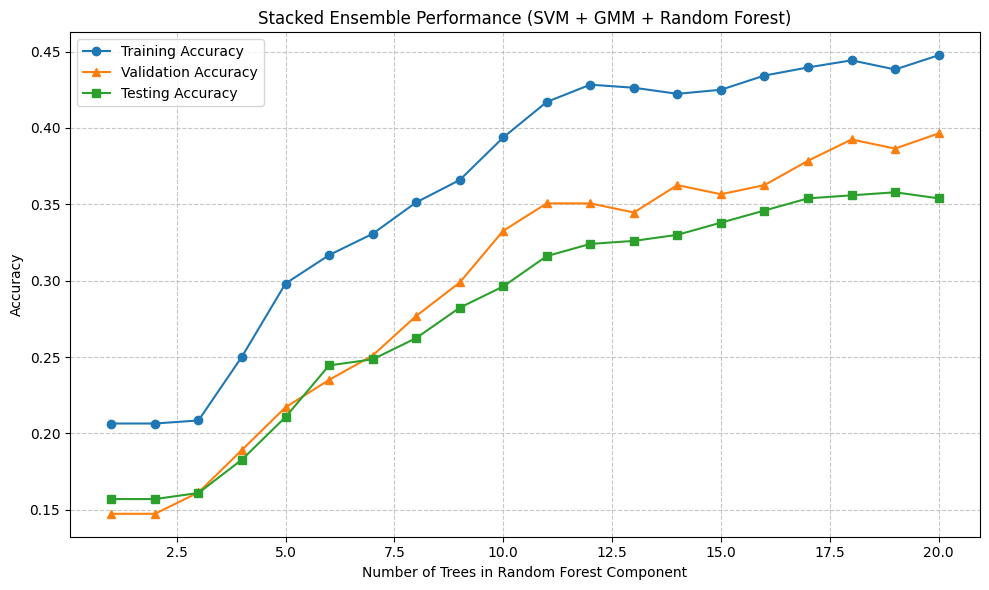

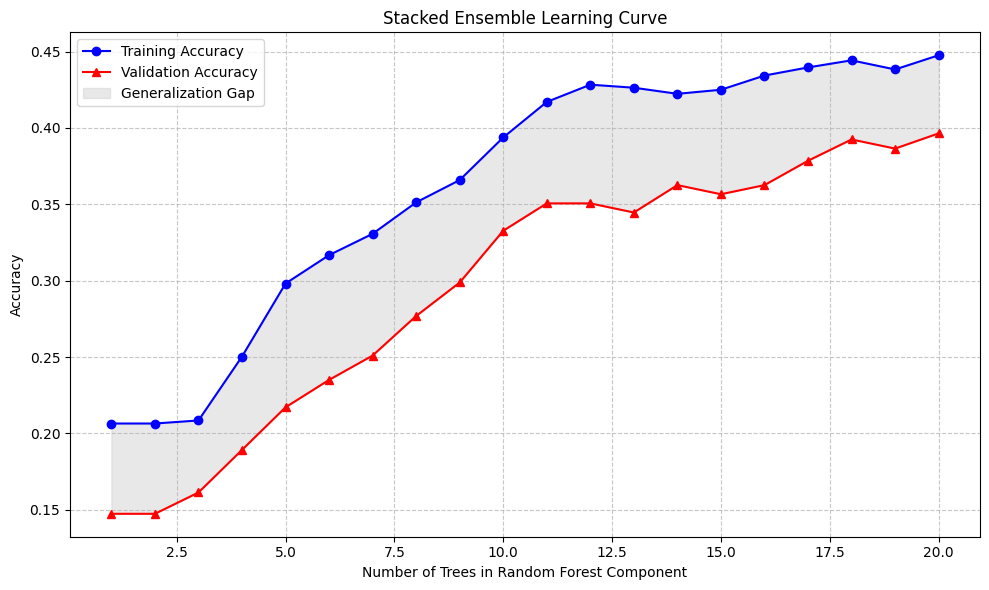

In [ ]:
# Run the stacked ensemble
print("\n--- Running Stacked Ensemble (SVM + GMM + Random Forest) ---")
stacked_model, stacked_train_accuracies, stacked_val_accuracies, stacked_test_accuracies, stacked_predictions = stacked_ensemble_with_graph(
    X_train_enhanced, y_train, X_val_enhanced, y_val, X_test_enhanced, y_test,
    n_estimators_rf=20, n_components_gmm=3, max_depth_rf=4
)

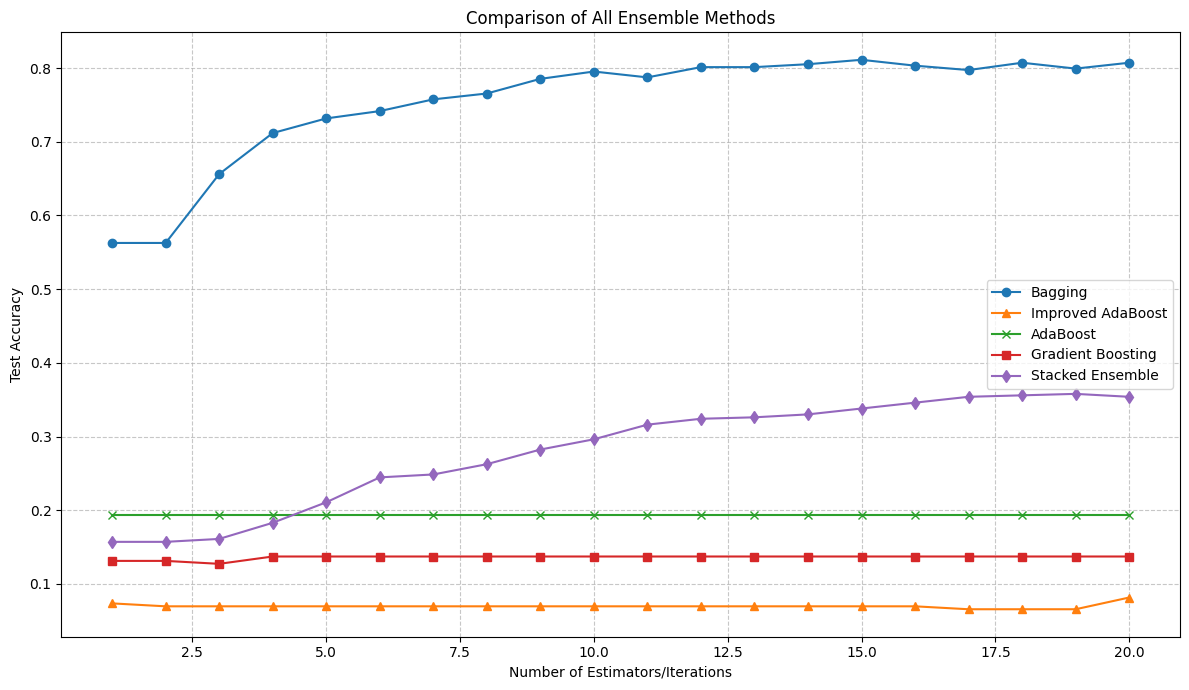

In [ ]:
plt.figure(figsize=(12, 7))
plt.plot(range(1, len(bagging_accuracies)+1), bagging_accuracies, label='Bagging', marker='o')
plt.plot(range(1, len(improved_adaboost_accuracies)+1), improved_adaboost_accuracies, label='Improved AdaBoost', marker='^')
plt.plot(range(1, len(adaboost_accuracies)+1), adaboost_accuracies, label='AdaBoost', marker='x')
plt.plot(range(1, len(gradient_boosting_accuracies)+1), gradient_boosting_accuracies, label='Gradient Boosting', marker='s')
plt.plot(range(1, len(stacked_test_accuracies)+1), stacked_test_accuracies, label='Stacked Ensemble', marker='d')
plt.xlabel('Number of Estimators/Iterations')
plt.ylabel('Test Accuracy')
plt.title('Comparison of All Ensemble Methods')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
def experiment_bagging_tree_depth(X_train, y_train, X_val, y_val, X_test, y_test, 
                                 n_estimators=20, depths=[None, 3, 5, 7, 10, 15]):
    """
    Experiment with different tree depths for bagging ensemble method.
    
    Args:
        X_train, y_train, X_val, y_val, X_test, y_test: Dataset splits
        n_estimators: Number of trees in the ensemble
        depths: List of max_depth values to test
    
    Returns:
        Dictionary of test accuracies for each depth
    """
    print("\n--- Bagging Tree Depth Experiment ---")
    n_samples = X_train.shape[0]
    sample_size = int(0.8 * n_samples)
    
    results = {}
    best_depth = None
    best_accuracy = 0
    
    for depth in depths:
        depth_name = str(depth) if depth is not None else "None (unlimited)"
        print(f"\nTesting Bagging with max_depth = {depth_name}")
        
        estimators = []
        test_accuracies = []
        
        for i in range(n_estimators):
            # Bootstrap sampling
            indices = np.random.choice(n_samples, sample_size, replace=True)
            X_sample, y_sample = X_train[indices], y_train[indices]
            
            # Train a decision tree with specified depth
            tree = DecisionTree(max_depth=depth, criterion='entropy', class_weight='balanced')
            tree.fit(X_sample, y_sample)
            estimators.append(tree)
            
            # Aggregate predictions
            def aggregate_predictions(X, estimators):
                predictions = np.array([tree.predict(X) for tree in estimators])
                return np.apply_along_axis(lambda x: Counter(x).most_common(1)[0][0], axis=0, arr=predictions)
            
            # Evaluate on test data
            y_test_pred = aggregate_predictions(X_test, estimators)
            test_accuracy = accuracy(y_test, y_test_pred)
            test_accuracies.append(test_accuracy)
            
            if i % 5 == 0 or i == n_estimators - 1:
                print(f"  Trees: {i+1}, Test Accuracy: {test_accuracy:.4f}")
        
        final_accuracy = test_accuracies[-1]
        results[depth] = test_accuracies
        
        if final_accuracy > best_accuracy:
            best_accuracy = final_accuracy
            best_depth = depth
    
    # Plot results
    plt.figure(figsize=(12, 7))
    for depth, accuracies in results.items():
        depth_name = str(depth) if depth is not None else "None"
        plt.plot(range(1, n_estimators + 1), accuracies, 
                 label=f'Depth = {depth_name}', marker='o', markersize=4)
    
    plt.xlabel('Number of Estimators')
    plt.ylabel('Test Accuracy')
    plt.title('Bagging: Impact of Tree Depth')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    best_depth_name = str(best_depth) if best_depth is not None else "None (unlimited)"
    print(f"\nBest Bagging Tree Depth: {best_depth_name} with accuracy {best_accuracy:.4f}")
    
    return results, best_depth

In [ ]:
def experiment_adaboost_tree_depth(X_train, y_train, X_val, y_val, X_test, y_test, 
                                 n_estimators=20, depths=[1, 2, 3, 5, 7, 10]):
    """
    Experiment with different tree depths for AdaBoost ensemble method.
    
    Args:
        X_train, y_train, X_val, y_val, X_test, y_test: Dataset splits
        n_estimators: Number of trees in the ensemble
        depths: List of max_depth values to test
    
    Returns:
        Dictionary of test accuracies for each depth
    """
    print("\n--- AdaBoost Tree Depth Experiment ---")
    
    results = {}
    best_depth = None
    best_accuracy = 0
    
    for depth in depths:
        print(f"\nTesting AdaBoost with max_depth = {depth}")
        
        # Run AdaBoost with current depth
        _, _, _, test_accuracies = adaboost_decision_trees_with_graph(
            X_train, y_train, X_val, y_val, X_test, y_test, 
            n_estimators=n_estimators, max_depth=depth
        )
        
        final_accuracy = test_accuracies[-1]
        results[depth] = test_accuracies
        
        if final_accuracy > best_accuracy:
            best_accuracy = final_accuracy
            best_depth = depth
    
    # Plot results
    plt.figure(figsize=(12, 7))
    for depth, accuracies in results.items():
        plt.plot(range(1, n_estimators + 1), accuracies, 
                 label=f'Depth = {depth}', marker='o', markersize=4)
    
    plt.xlabel('Number of Estimators')
    plt.ylabel('Test Accuracy')
    plt.title('AdaBoost: Impact of Tree Depth')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    print(f"\nBest AdaBoost Tree Depth: {best_depth} with accuracy {best_accuracy:.4f}")
    
    return results, best_depth

In [ ]:
def experiment_improved_adaboost_tree_depth(X_train, y_train, X_val, y_val, X_test, y_test, 
                                         n_estimators=20, depths=[1, 2, 3, 5, 7, 10]):
    """
    Experiment with different tree depths for Improved AdaBoost ensemble method.
    
    Args:
        X_train, y_train, X_val, y_val, X_test, y_test: Dataset splits
        n_estimators: Number of trees in the ensemble
        depths: List of max_depth values to test
    
    Returns:
        Dictionary of test accuracies for each depth
    """
    print("\n--- Improved AdaBoost Tree Depth Experiment ---")
    
    results = {}
    best_depth = None
    best_accuracy = 0
    
    for depth in depths:
        print(f"\nTesting Improved AdaBoost with max_depth = {depth}")
        
        # Run Improved AdaBoost with current depth
        _, _, test_accuracies, _, _ = improved_adaboost_decision_trees_with_graph(
            X_train, y_train, X_val, y_val, X_test, y_test, 
            n_estimators=n_estimators, max_depth=depth
        )
        
        final_accuracy = test_accuracies[-1]
        results[depth] = test_accuracies
        
        if final_accuracy > best_accuracy:
            best_accuracy = final_accuracy
            best_depth = depth
    
    # Plot results
    plt.figure(figsize=(12, 7))
    for depth, accuracies in results.items():
        plt.plot(range(1, n_estimators + 1), accuracies, 
                 label=f'Depth = {depth}', marker='o', markersize=4)
    
    plt.xlabel('Number of Estimators')
    plt.ylabel('Test Accuracy')
    plt.title('Improved AdaBoost: Impact of Tree Depth')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    print(f"\nBest Improved AdaBoost Tree Depth: {best_depth} with accuracy {best_accuracy:.4f}")
    
    return results, best_depth


In [ ]:
def experiment_gradient_boosting_tree_depth(X_train, y_train, X_val, y_val, X_test, y_test, 
                                         n_estimators=20, depths=[1, 2, 3, 5, 7, 10],
                                         learning_rate=0.1):
    """
    Experiment with different tree depths for Gradient Boosting ensemble method.
    
    Args:
        X_train, y_train, X_val, y_val, X_test, y_test: Dataset splits
        n_estimators: Number of trees in the ensemble
        depths: List of max_depth values to test
        learning_rate: Learning rate for gradient boosting
    
    Returns:
        Dictionary of test accuracies for each depth
    """
    print("\n--- Gradient Boosting Tree Depth Experiment ---")
    
    results = {}
    best_depth = None
    best_accuracy = 0
    
    for depth in depths:
        print(f"\nTesting Gradient Boosting with max_depth = {depth}")
        
        # Run Gradient Boosting with current depth
        _, test_accuracies, _, _ = gradient_boosting_with_graph(
            X_train, y_train, X_val, y_val, X_test, y_test, 
            n_estimators=n_estimators, max_depth=depth, learning_rate=learning_rate
        )
        
        final_accuracy = test_accuracies[-1]
        results[depth] = test_accuracies
        
        if final_accuracy > best_accuracy:
            best_accuracy = final_accuracy
            best_depth = depth
    
    # Plot results
    plt.figure(figsize=(12, 7))
    for depth, accuracies in results.items():
        plt.plot(range(1, n_estimators + 1), accuracies, 
                 label=f'Depth = {depth}', marker='o', markersize=4)
    
    plt.xlabel('Number of Estimators')
    plt.ylabel('Test Accuracy')
    plt.title('Gradient Boosting: Impact of Tree Depth')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    print(f"\nBest Gradient Boosting Tree Depth: {best_depth} with accuracy {best_accuracy:.4f}")
    
    return results, best_depth


In [ ]:
def experiment_stacked_ensemble_tree_depth(X_train, y_train, X_val, y_val, X_test, y_test, 
                                         n_estimators_rf=20, depths=[3, 4, 5, 7, 10, None],
                                         n_components_gmm=3):
    """
    Experiment with different RF tree depths for the Stacked Ensemble method.
    
    Args:
        X_train, y_train, X_val, y_val, X_test, y_test: Dataset splits
        n_estimators_rf: Number of RF trees in the ensemble
        depths: List of max_depth values to test for Random Forest
        n_components_gmm: Number of GMM components
    
    Returns:
        Dictionary of test accuracies for each depth
    """
    print("\n--- Stacked Ensemble (RF) Tree Depth Experiment ---")
    
    results = {}
    best_depth = None
    best_accuracy = 0
    
    for depth in depths:
        depth_name = str(depth) if depth is not None else "None (unlimited)"
        print(f"\nTesting Stacked Ensemble with RF max_depth = {depth_name}")
        
        # Run Stacked Ensemble with current depth
        _, _, _, test_accuracies, _ = stacked_ensemble_with_graph(
            X_train, y_train, X_val, y_val, X_test, y_test,
            n_estimators_rf=n_estimators_rf, 
            n_components_gmm=n_components_gmm, 
            max_depth_rf=depth
        )
        
        final_accuracy = test_accuracies[-1]
        results[depth] = test_accuracies
        
        if final_accuracy > best_accuracy:
            best_accuracy = final_accuracy
            best_depth = depth
    
    # Plot results
    plt.figure(figsize=(12, 7))
    for depth, accuracies in results.items():
        depth_name = str(depth) if depth is not None else "None"
        plt.plot(range(1, n_estimators_rf + 1), accuracies, 
                 label=f'Depth = {depth_name}', marker='o', markersize=4)
    
    plt.xlabel('Number of RF Trees')
    plt.ylabel('Test Accuracy')
    plt.title('Stacked Ensemble: Impact of RF Tree Depth')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    best_depth_name = str(best_depth) if best_depth is not None else "None (unlimited)"
    print(f"\nBest Stacked Ensemble RF Tree Depth: {best_depth_name} with accuracy {best_accuracy:.4f}")
    
    return results, best_depth

In [ ]:
def compare_best_methods_by_depth(results_dict, n_estimators=20):
    """
    Compare the best accuracy of each method at different depths.
    
    Args:
        results_dict: Dictionary with method names as keys and (results, best_depth) tuples as values
        n_estimators: Number of estimators used in the experiments
    """
    # Extract best accuracy for each depth for each method
    comparison = {}
    
    for method_name, (results, _) in results_dict.items():
        comparison[method_name] = {}
        for depth, accuracies in results.items():
            # Use the final accuracy (with all estimators)
            comparison[method_name][depth] = accuracies[-1]
    
    # Plot comparison
    plt.figure(figsize=(14, 8))
    
    # Prepare data for plotting
    for method_name, depth_accuracies in comparison.items():
        depths = []
        accuracies = []
        
        for depth, acc in sorted(depth_accuracies.items(), key=lambda x: (x[0] is None, x[0])):
            depth_val = depth if depth is not None else 20  # Plot None as a large value
            depths.append(depth_val)
            accuracies.append(acc)
        
        plt.plot(depths, accuracies, marker='o', linewidth=2, markersize=8, label=method_name)
    
    # Add labels and annotations
    plt.xlabel('Tree Depth')
    plt.ylabel('Test Accuracy')
    plt.title('Best Accuracy by Tree Depth for Different Ensemble Methods')
    
    # Adjust x-axis to show "None" for unlimited depth
    x_ticks = sorted(set([d for method in comparison.values() for d in method.keys() if d is not None]))
    x_ticks.append(20)  # Add position for None
    x_tick_labels = [str(x) for x in x_ticks]
    x_tick_labels[-1] = 'None'
    plt.xticks(x_ticks, x_tick_labels)
    
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    
    # Print best depth for each method
    print("\n--- Best Tree Depths Summary ---")
    for method_name, (_, best_depth) in results_dict.items():
        best_depth_name = str(best_depth) if best_depth is not None else "None (unlimited)"
        best_accuracy = comparison[method_name][best_depth]
        print(f"{method_name}: Best depth = {best_depth_name}, Accuracy = {best_accuracy:.4f}")


In [ ]:
def run_tree_depth_experiments(X_train, y_train, X_val, y_val, X_test, y_test, n_estimators=15):
    """Run experiments with different tree depths for all ensemble methods."""
    # Define depths to test (different ranges for different methods)
    bagging_depths = [None, 3, 5, 10, 15]
    adaboost_depths = [1, 2, 3, 5, 7]
    gradboost_depths = [1, 2, 3, 5, 7]
    stacked_depths = [3, 5, 7, None]
    
    # Run experiments
    bagging_results = experiment_bagging_tree_depth(
        X_train, y_train, X_val, y_val, X_test, y_test, 
        n_estimators=n_estimators, depths=bagging_depths
    )
    
    adaboost_results = experiment_adaboost_tree_depth(
        X_train, y_train, X_val, y_val, X_test, y_test, 
        n_estimators=n_estimators, depths=adaboost_depths
    )
    
    improved_adaboost_results = experiment_improved_adaboost_tree_depth(
        X_train, y_train, X_val, y_val, X_test, y_test, 
        n_estimators=n_estimators, depths=adaboost_depths
    )
    
    gradboost_results = experiment_gradient_boosting_tree_depth(
        X_train, y_train, X_val, y_val, X_test, y_test, 
        n_estimators=n_estimators, depths=gradboost_depths
    )
    
    stacked_results = experiment_stacked_ensemble_tree_depth(
        X_train, y_train, X_val, y_val, X_test, y_test, 
        n_estimators_rf=n_estimators, depths=stacked_depths
    )
    
    # Compare all methods
    results_dict = {
        'Bagging': bagging_results,
        'AdaBoost': adaboost_results,
        'Improved AdaBoost': improved_adaboost_results,
        'Gradient Boosting': gradboost_results,
        'Stacked Ensemble': stacked_results
    }
    
    compare_best_methods_by_depth(results_dict, n_estimators)
    
    return results_dict




===== TREE DEPTH EXPERIMENTS =====

--- Bagging Tree Depth Experiment ---

Testing Bagging with max_depth = None (unlimited)
  Trees: 1, Test Accuracy: 0.5905
  Trees: 6, Test Accuracy: 0.7435
  Trees: 11, Test Accuracy: 0.7674
  Trees: 15, Test Accuracy: 0.7833

Testing Bagging with max_depth = 3
  Trees: 1, Test Accuracy: 0.1590
  Trees: 6, Test Accuracy: 0.1829
  Trees: 11, Test Accuracy: 0.1750
  Trees: 15, Test Accuracy: 0.1650

Testing Bagging with max_depth = 5
  Trees: 1, Test Accuracy: 0.3877
  Trees: 6, Test Accuracy: 0.4553
  Trees: 11, Test Accuracy: 0.5229
  Trees: 15, Test Accuracy: 0.5686

Testing Bagging with max_depth = 10
  Trees: 1, Test Accuracy: 0.5268
  Trees: 6, Test Accuracy: 0.7217
  Trees: 11, Test Accuracy: 0.7833
  Trees: 15, Test Accuracy: 0.7813

Testing Bagging with max_depth = 15
  Trees: 1, Test Accuracy: 0.5646
  Trees: 6, Test Accuracy: 0.7316
  Trees: 11, Test Accuracy: 0.7753
  Trees: 15, Test Accuracy: 0.8012


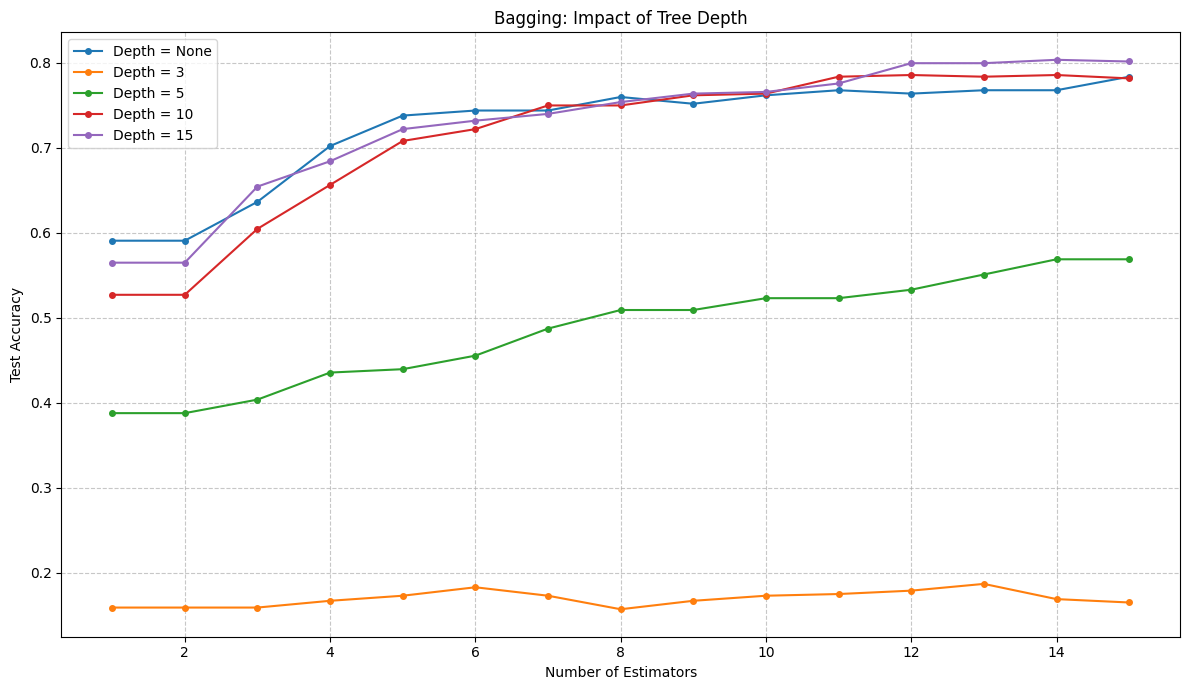


Best Bagging Tree Depth: 15 with accuracy 0.8012

--- AdaBoost Tree Depth Experiment ---

Testing AdaBoost with max_depth = 1

Testing AdaBoost on Decision Trees...
AdaBoost with 1 estimators - Train Accuracy: 0.0737, Validation Accuracy: 0.0697, Test Accuracy: 0.0716
AdaBoost with 2 estimators - Train Accuracy: 0.0737, Validation Accuracy: 0.0697, Test Accuracy: 0.0716
AdaBoost with 3 estimators - Train Accuracy: 0.0737, Validation Accuracy: 0.0697, Test Accuracy: 0.0716
AdaBoost with 4 estimators - Train Accuracy: 0.0737, Validation Accuracy: 0.0697, Test Accuracy: 0.0716
AdaBoost with 5 estimators - Train Accuracy: 0.0737, Validation Accuracy: 0.0697, Test Accuracy: 0.0716
AdaBoost with 6 estimators - Train Accuracy: 0.0737, Validation Accuracy: 0.0697, Test Accuracy: 0.0716
AdaBoost with 7 estimators - Train Accuracy: 0.0737, Validation Accuracy: 0.0697, Test Accuracy: 0.0716
AdaBoost with 8 estimators - Train Accuracy: 0.0737, Validation Accuracy: 0.0697, Test Accuracy: 0.0716
Ad

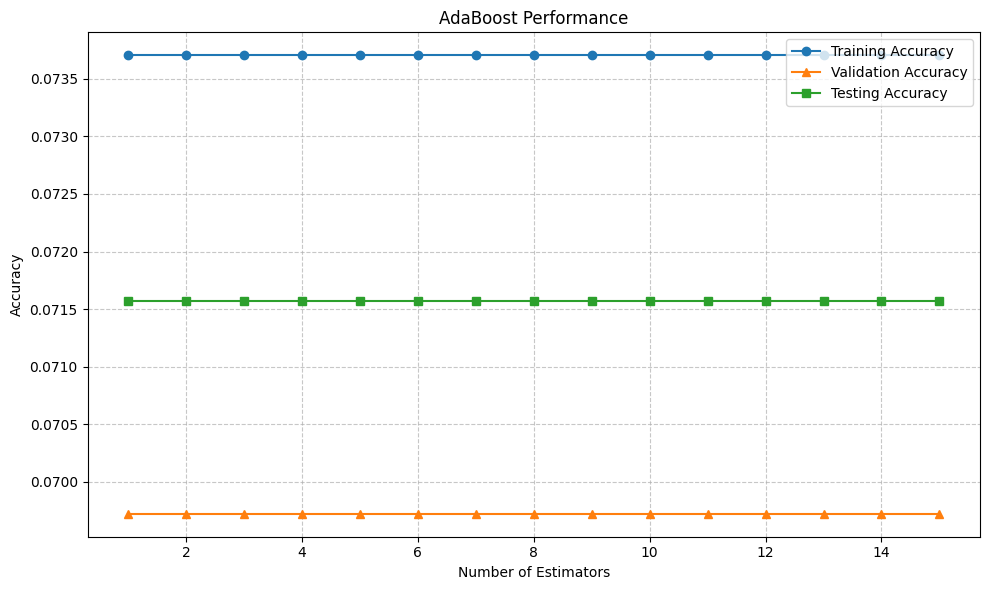


Testing AdaBoost with max_depth = 2

Testing AdaBoost on Decision Trees...
AdaBoost with 1 estimators - Train Accuracy: 0.1222, Validation Accuracy: 0.1195, Test Accuracy: 0.1153
AdaBoost with 2 estimators - Train Accuracy: 0.1222, Validation Accuracy: 0.1195, Test Accuracy: 0.1153
AdaBoost with 3 estimators - Train Accuracy: 0.1222, Validation Accuracy: 0.1195, Test Accuracy: 0.1153
AdaBoost with 4 estimators - Train Accuracy: 0.1222, Validation Accuracy: 0.1195, Test Accuracy: 0.1153
AdaBoost with 5 estimators - Train Accuracy: 0.1222, Validation Accuracy: 0.1195, Test Accuracy: 0.1153
AdaBoost with 6 estimators - Train Accuracy: 0.1222, Validation Accuracy: 0.1195, Test Accuracy: 0.1153
AdaBoost with 7 estimators - Train Accuracy: 0.1222, Validation Accuracy: 0.1195, Test Accuracy: 0.1153
AdaBoost with 8 estimators - Train Accuracy: 0.1222, Validation Accuracy: 0.1195, Test Accuracy: 0.1153
AdaBoost with 9 estimators - Train Accuracy: 0.1222, Validation Accuracy: 0.1195, Test Accur

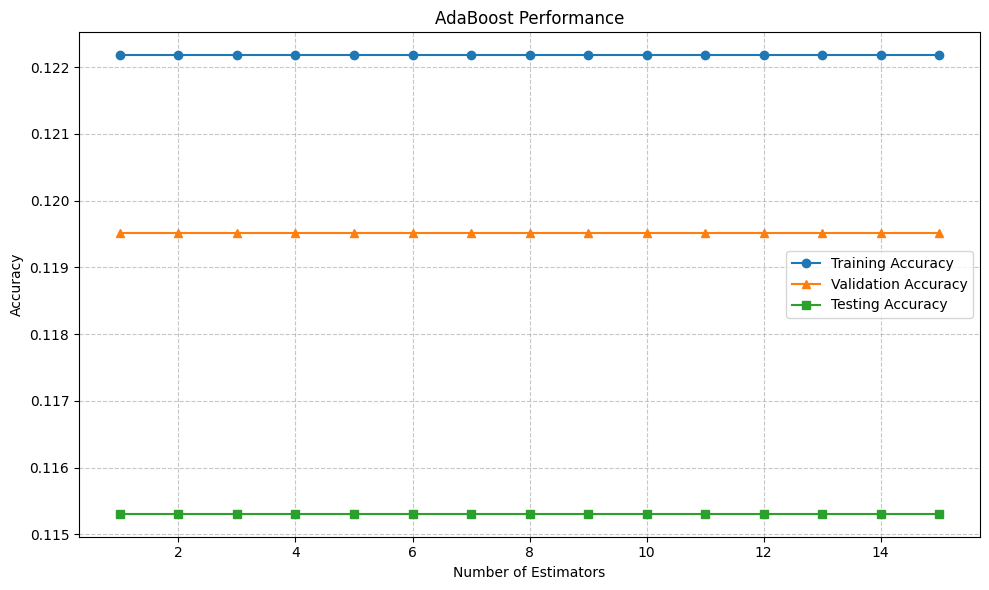


Testing AdaBoost with max_depth = 3

Testing AdaBoost on Decision Trees...
AdaBoost with 1 estimators - Train Accuracy: 0.2078, Validation Accuracy: 0.1892, Test Accuracy: 0.1928
AdaBoost with 2 estimators - Train Accuracy: 0.2078, Validation Accuracy: 0.1892, Test Accuracy: 0.1928
AdaBoost with 3 estimators - Train Accuracy: 0.2078, Validation Accuracy: 0.1892, Test Accuracy: 0.1928
AdaBoost with 4 estimators - Train Accuracy: 0.2078, Validation Accuracy: 0.1892, Test Accuracy: 0.1928
AdaBoost with 5 estimators - Train Accuracy: 0.2078, Validation Accuracy: 0.1892, Test Accuracy: 0.1928
AdaBoost with 6 estimators - Train Accuracy: 0.2078, Validation Accuracy: 0.1892, Test Accuracy: 0.1928
AdaBoost with 7 estimators - Train Accuracy: 0.2078, Validation Accuracy: 0.1892, Test Accuracy: 0.1928
AdaBoost with 8 estimators - Train Accuracy: 0.2078, Validation Accuracy: 0.1892, Test Accuracy: 0.1928
AdaBoost with 9 estimators - Train Accuracy: 0.2078, Validation Accuracy: 0.1892, Test Accur

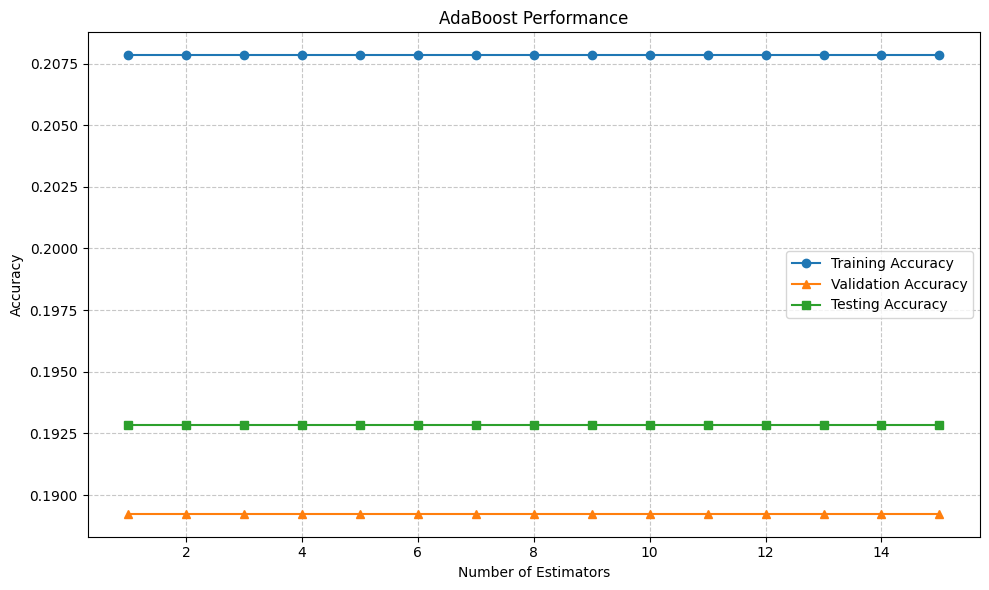


Testing AdaBoost with max_depth = 5

Testing AdaBoost on Decision Trees...
AdaBoost with 1 estimators - Train Accuracy: 0.5279, Validation Accuracy: 0.4203, Test Accuracy: 0.4592
AdaBoost with 2 estimators - Train Accuracy: 0.5279, Validation Accuracy: 0.4203, Test Accuracy: 0.4592
AdaBoost with 3 estimators - Train Accuracy: 0.5279, Validation Accuracy: 0.4203, Test Accuracy: 0.4592
AdaBoost with 4 estimators - Train Accuracy: 0.5279, Validation Accuracy: 0.4203, Test Accuracy: 0.4592
AdaBoost with 5 estimators - Train Accuracy: 0.5279, Validation Accuracy: 0.4203, Test Accuracy: 0.4592
AdaBoost with 6 estimators - Train Accuracy: 0.5279, Validation Accuracy: 0.4203, Test Accuracy: 0.4592
AdaBoost with 7 estimators - Train Accuracy: 0.5279, Validation Accuracy: 0.4203, Test Accuracy: 0.4592
AdaBoost with 8 estimators - Train Accuracy: 0.5279, Validation Accuracy: 0.4203, Test Accuracy: 0.4592
AdaBoost with 9 estimators - Train Accuracy: 0.5279, Validation Accuracy: 0.4203, Test Accur

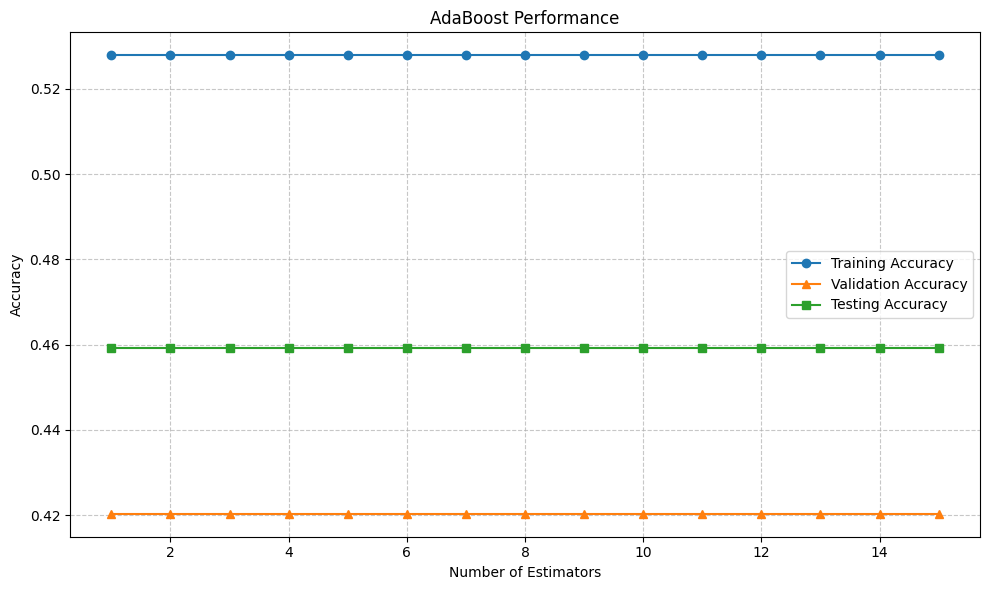


Testing AdaBoost with max_depth = 7

Testing AdaBoost on Decision Trees...
AdaBoost with 1 estimators - Train Accuracy: 0.8333, Validation Accuracy: 0.5458, Test Accuracy: 0.5268
AdaBoost with 2 estimators - Train Accuracy: 0.8333, Validation Accuracy: 0.5458, Test Accuracy: 0.5268
AdaBoost with 3 estimators - Train Accuracy: 0.8333, Validation Accuracy: 0.5458, Test Accuracy: 0.5268
AdaBoost with 4 estimators - Train Accuracy: 0.8333, Validation Accuracy: 0.5458, Test Accuracy: 0.5268
AdaBoost with 5 estimators - Train Accuracy: 0.8333, Validation Accuracy: 0.5458, Test Accuracy: 0.5268
AdaBoost with 6 estimators - Train Accuracy: 0.8333, Validation Accuracy: 0.5458, Test Accuracy: 0.5268
AdaBoost with 7 estimators - Train Accuracy: 0.8333, Validation Accuracy: 0.5458, Test Accuracy: 0.5268
AdaBoost with 8 estimators - Train Accuracy: 0.8333, Validation Accuracy: 0.5458, Test Accuracy: 0.5268
AdaBoost with 9 estimators - Train Accuracy: 0.8333, Validation Accuracy: 0.5458, Test Accur

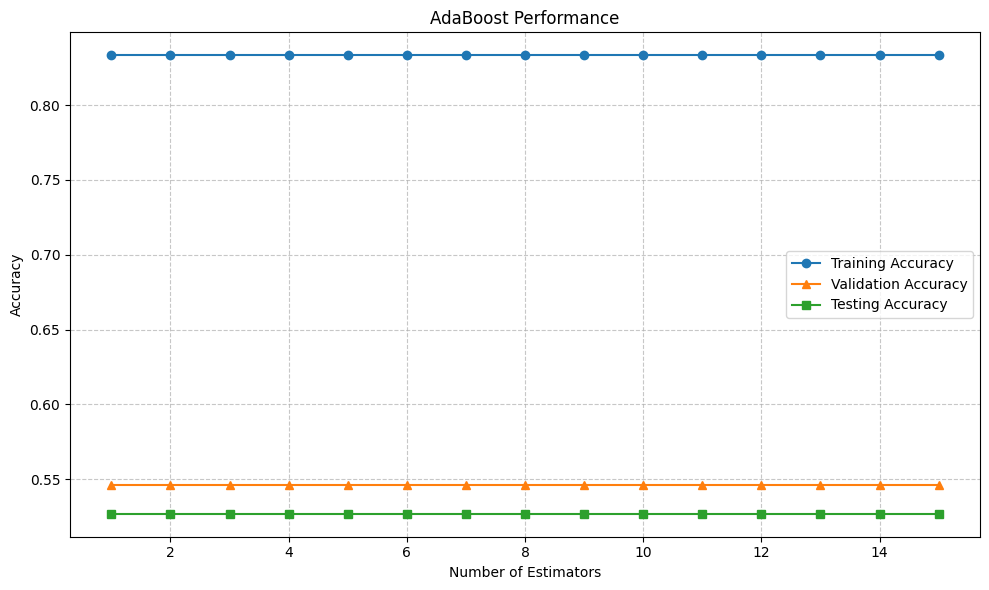

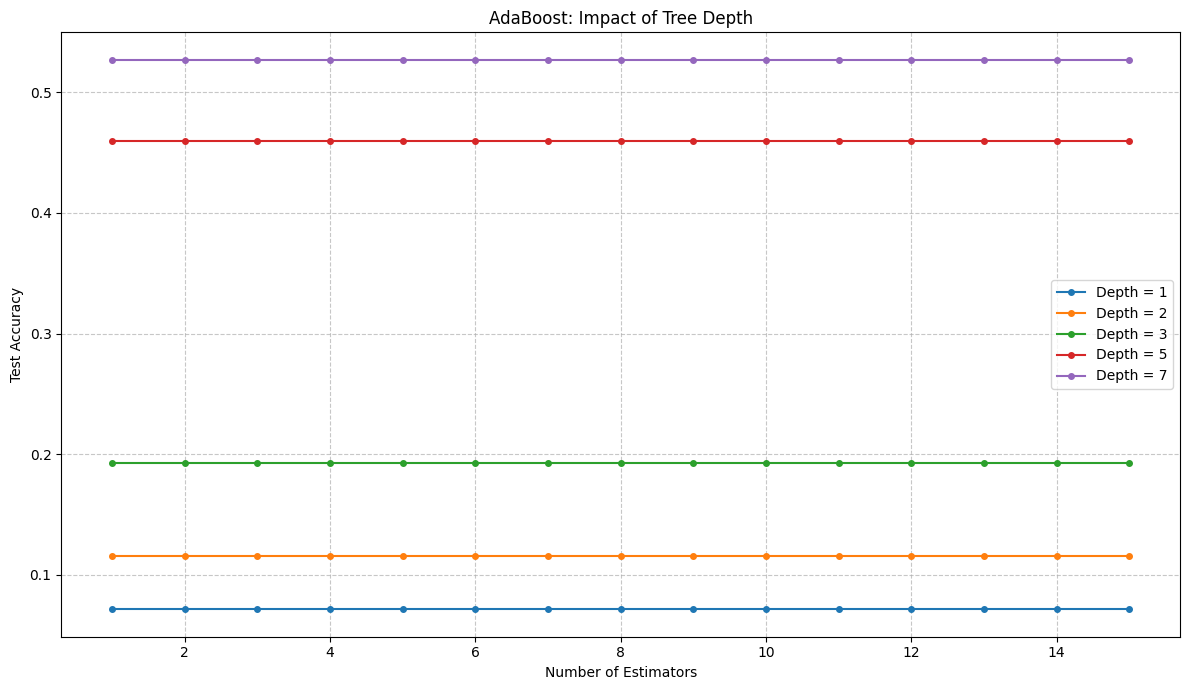


Best AdaBoost Tree Depth: 7 with accuracy 0.5268

--- Improved AdaBoost Tree Depth Experiment ---

Testing Improved AdaBoost with max_depth = 1

Testing Improved AdaBoost on Decision Trees...
Improved AdaBoost with 1 estimators - Train Accuracy: 0.0777, Validation Accuracy: 0.0757, Test Accuracy: 0.0716
Improved AdaBoost with 2 estimators - Train Accuracy: 0.0777, Validation Accuracy: 0.0757, Test Accuracy: 0.0716
Improved AdaBoost with 3 estimators - Train Accuracy: 0.0777, Validation Accuracy: 0.0757, Test Accuracy: 0.0716
Improved AdaBoost with 4 estimators - Train Accuracy: 0.0777, Validation Accuracy: 0.0757, Test Accuracy: 0.0716
Improved AdaBoost with 5 estimators - Train Accuracy: 0.0777, Validation Accuracy: 0.0757, Test Accuracy: 0.0716
Improved AdaBoost with 6 estimators - Train Accuracy: 0.0777, Validation Accuracy: 0.0757, Test Accuracy: 0.0716
Improved AdaBoost with 7 estimators - Train Accuracy: 0.0777, Validation Accuracy: 0.0757, Test Accuracy: 0.0716
Improved AdaBoos

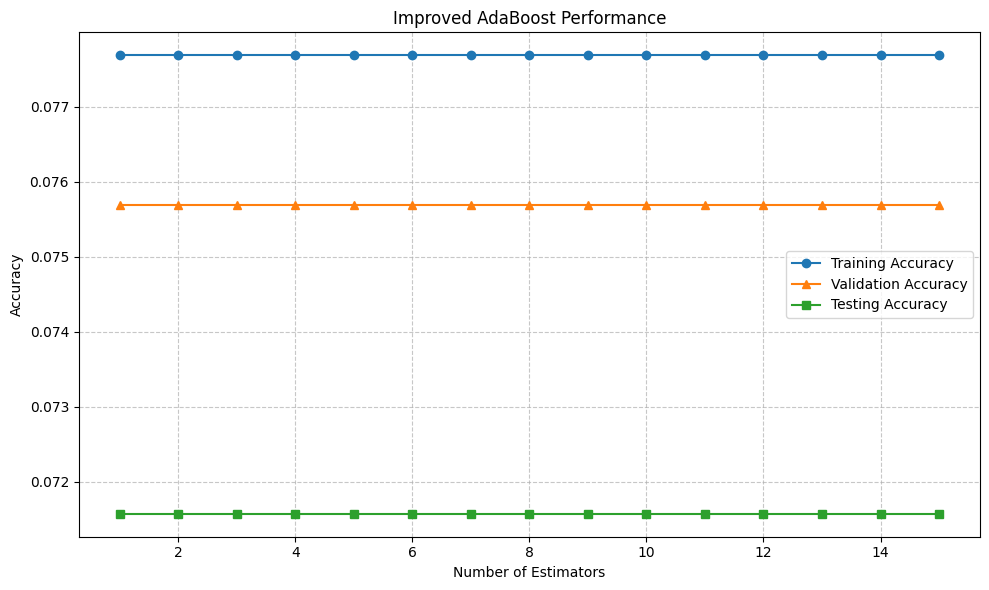


Testing Improved AdaBoost with max_depth = 2

Testing Improved AdaBoost on Decision Trees...
Improved AdaBoost with 1 estimators - Train Accuracy: 0.0757, Validation Accuracy: 0.0737, Test Accuracy: 0.0716
Improved AdaBoost with 2 estimators - Train Accuracy: 0.0737, Validation Accuracy: 0.0677, Test Accuracy: 0.0696
Improved AdaBoost with 3 estimators - Train Accuracy: 0.0737, Validation Accuracy: 0.0677, Test Accuracy: 0.0696
Improved AdaBoost with 4 estimators - Train Accuracy: 0.0737, Validation Accuracy: 0.0677, Test Accuracy: 0.0696
Improved AdaBoost with 5 estimators - Train Accuracy: 0.0737, Validation Accuracy: 0.0677, Test Accuracy: 0.0696
Improved AdaBoost with 6 estimators - Train Accuracy: 0.0737, Validation Accuracy: 0.0677, Test Accuracy: 0.0696
Improved AdaBoost with 7 estimators - Train Accuracy: 0.0737, Validation Accuracy: 0.0677, Test Accuracy: 0.0696
Improved AdaBoost with 8 estimators - Train Accuracy: 0.0737, Validation Accuracy: 0.0677, Test Accuracy: 0.0696
Im

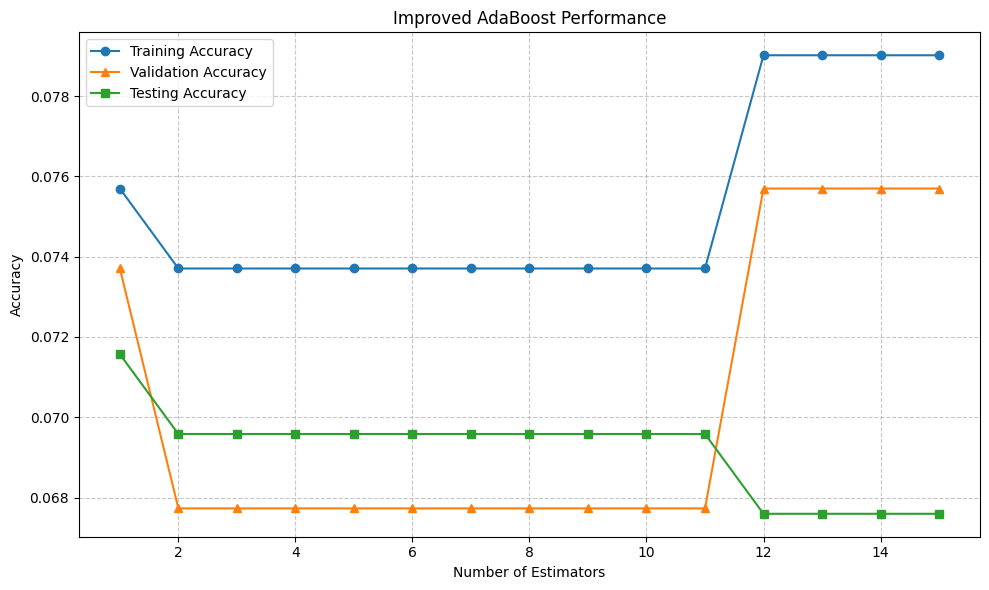


Testing Improved AdaBoost with max_depth = 3

Testing Improved AdaBoost on Decision Trees...
Improved AdaBoost with 1 estimators - Train Accuracy: 0.0624, Validation Accuracy: 0.0578, Test Accuracy: 0.0596
Improved AdaBoost with 2 estimators - Train Accuracy: 0.0677, Validation Accuracy: 0.0697, Test Accuracy: 0.0696
Improved AdaBoost with 3 estimators - Train Accuracy: 0.0677, Validation Accuracy: 0.0677, Test Accuracy: 0.0656
Improved AdaBoost with 4 estimators - Train Accuracy: 0.0677, Validation Accuracy: 0.0677, Test Accuracy: 0.0656
Improved AdaBoost with 5 estimators - Train Accuracy: 0.0677, Validation Accuracy: 0.0677, Test Accuracy: 0.0656
Improved AdaBoost with 6 estimators - Train Accuracy: 0.0584, Validation Accuracy: 0.0598, Test Accuracy: 0.0596
Improved AdaBoost with 7 estimators - Train Accuracy: 0.0564, Validation Accuracy: 0.0558, Test Accuracy: 0.0557
Improved AdaBoost with 8 estimators - Train Accuracy: 0.0564, Validation Accuracy: 0.0558, Test Accuracy: 0.0557
Im

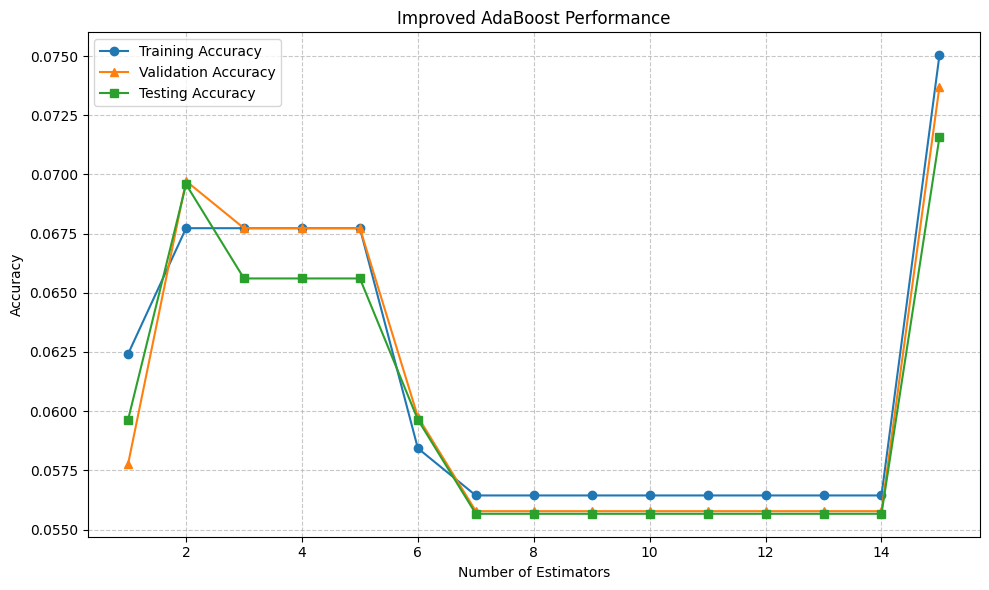


Testing Improved AdaBoost with max_depth = 5

Testing Improved AdaBoost on Decision Trees...
Improved AdaBoost with 1 estimators - Train Accuracy: 0.0737, Validation Accuracy: 0.0737, Test Accuracy: 0.0736
Improved AdaBoost with 2 estimators - Train Accuracy: 0.5139, Validation Accuracy: 0.4064, Test Accuracy: 0.3877
Improved AdaBoost with 3 estimators - Train Accuracy: 0.3984, Validation Accuracy: 0.3287, Test Accuracy: 0.2863
Improved AdaBoost with 4 estimators - Train Accuracy: 0.4197, Validation Accuracy: 0.3386, Test Accuracy: 0.2962
Improved AdaBoost with 5 estimators - Train Accuracy: 0.4761, Validation Accuracy: 0.3625, Test Accuracy: 0.3241
Improved AdaBoost with 6 estimators - Train Accuracy: 0.5750, Validation Accuracy: 0.4323, Test Accuracy: 0.4056
Improved AdaBoost with 7 estimators - Train Accuracy: 0.7224, Validation Accuracy: 0.5259, Test Accuracy: 0.5010
Improved AdaBoost with 8 estimators - Train Accuracy: 0.7543, Validation Accuracy: 0.5259, Test Accuracy: 0.5109
Im

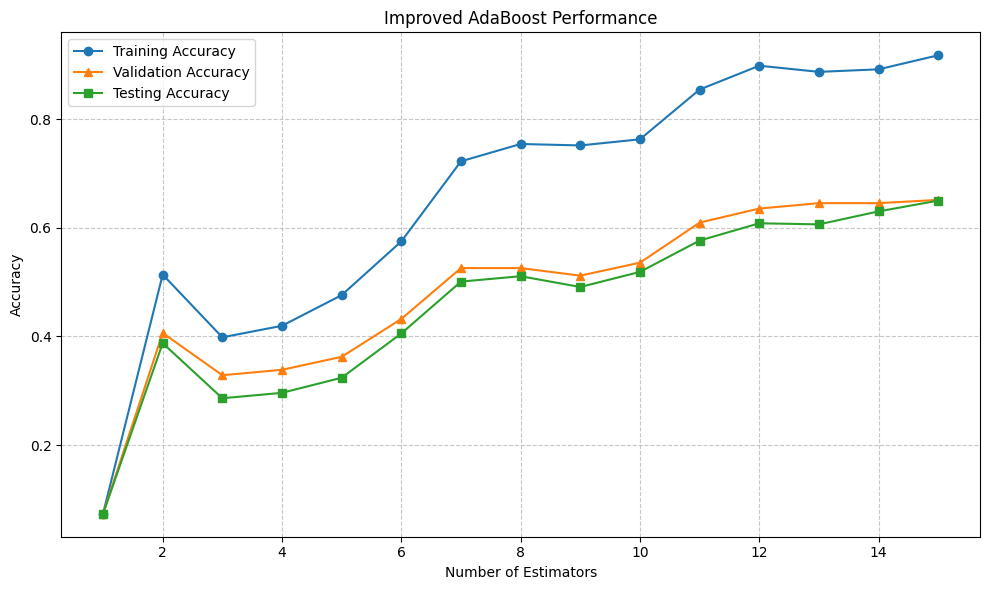


Testing Improved AdaBoost with max_depth = 7

Testing Improved AdaBoost on Decision Trees...
Improved AdaBoost with 1 estimators - Train Accuracy: 0.7875, Validation Accuracy: 0.4940, Test Accuracy: 0.5149
Improved AdaBoost with 2 estimators - Train Accuracy: 0.5093, Validation Accuracy: 0.3267, Test Accuracy: 0.3260
Improved AdaBoost with 3 estimators - Train Accuracy: 0.6009, Validation Accuracy: 0.3307, Test Accuracy: 0.3439
Improved AdaBoost with 4 estimators - Train Accuracy: 0.8838, Validation Accuracy: 0.5080, Test Accuracy: 0.5010
Improved AdaBoost with 5 estimators - Train Accuracy: 0.9110, Validation Accuracy: 0.5319, Test Accuracy: 0.5567
Improved AdaBoost with 6 estimators - Train Accuracy: 0.9602, Validation Accuracy: 0.5936, Test Accuracy: 0.6064
Improved AdaBoost with 7 estimators - Train Accuracy: 0.9714, Validation Accuracy: 0.6056, Test Accuracy: 0.6402
Improved AdaBoost with 8 estimators - Train Accuracy: 0.9754, Validation Accuracy: 0.6355, Test Accuracy: 0.6581
Im

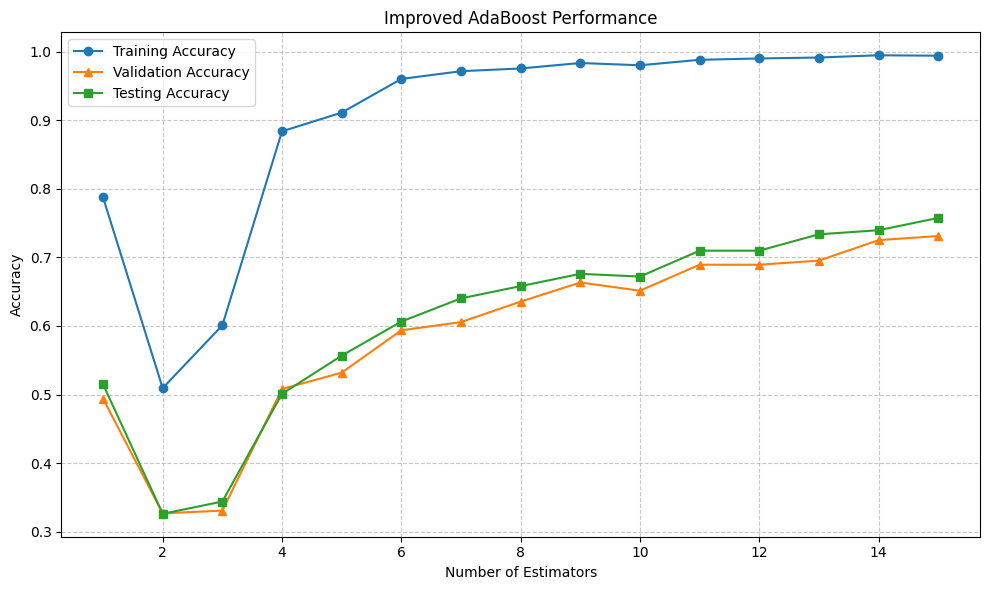

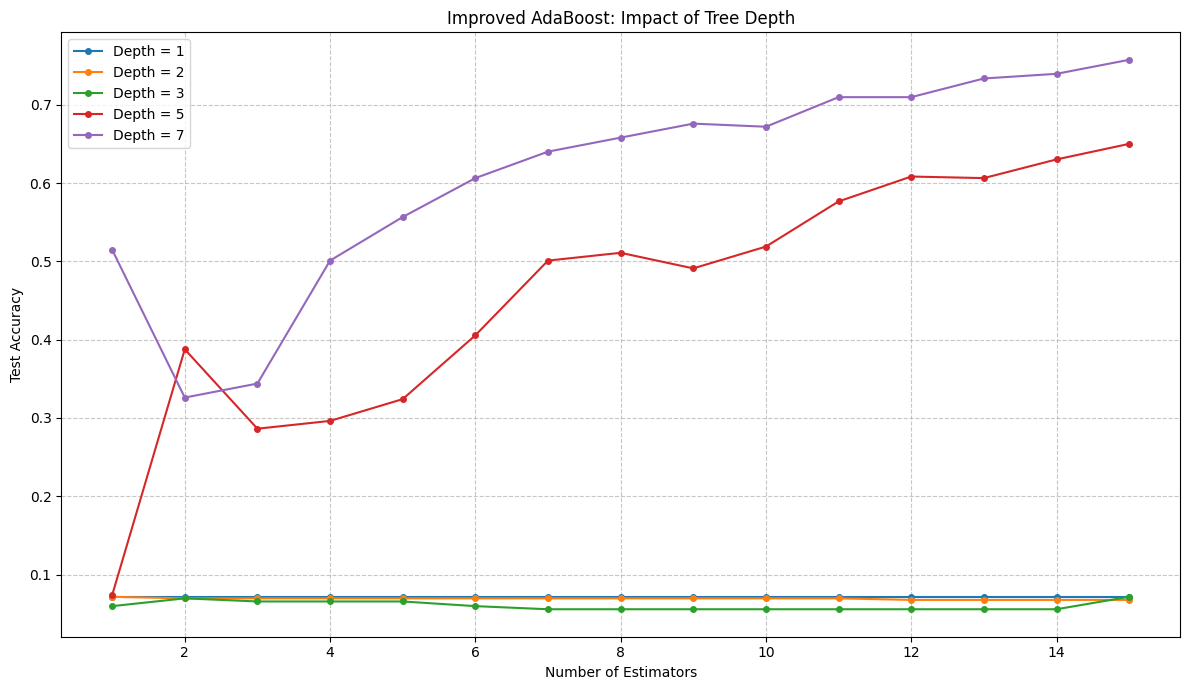


Best Improved AdaBoost Tree Depth: 7 with accuracy 0.7575

--- Gradient Boosting Tree Depth Experiment ---

Testing Gradient Boosting with max_depth = 1

Testing Gradient Boosting on Decision Trees...
Gradient Boosting with 1 iterations - Train Accuracy: 0.0153, Validation Accuracy: 0.0139, Test Accuracy: 0.0159
Gradient Boosting with 2 iterations - Train Accuracy: 0.0153, Validation Accuracy: 0.0139, Test Accuracy: 0.0159
Gradient Boosting with 3 iterations - Train Accuracy: 0.0153, Validation Accuracy: 0.0139, Test Accuracy: 0.0159
Gradient Boosting with 4 iterations - Train Accuracy: 0.0153, Validation Accuracy: 0.0139, Test Accuracy: 0.0159
Gradient Boosting with 5 iterations - Train Accuracy: 0.0153, Validation Accuracy: 0.0139, Test Accuracy: 0.0159
Gradient Boosting with 6 iterations - Train Accuracy: 0.0153, Validation Accuracy: 0.0139, Test Accuracy: 0.0159
Gradient Boosting with 7 iterations - Train Accuracy: 0.0153, Validation Accuracy: 0.0139, Test Accuracy: 0.0159
Gradien

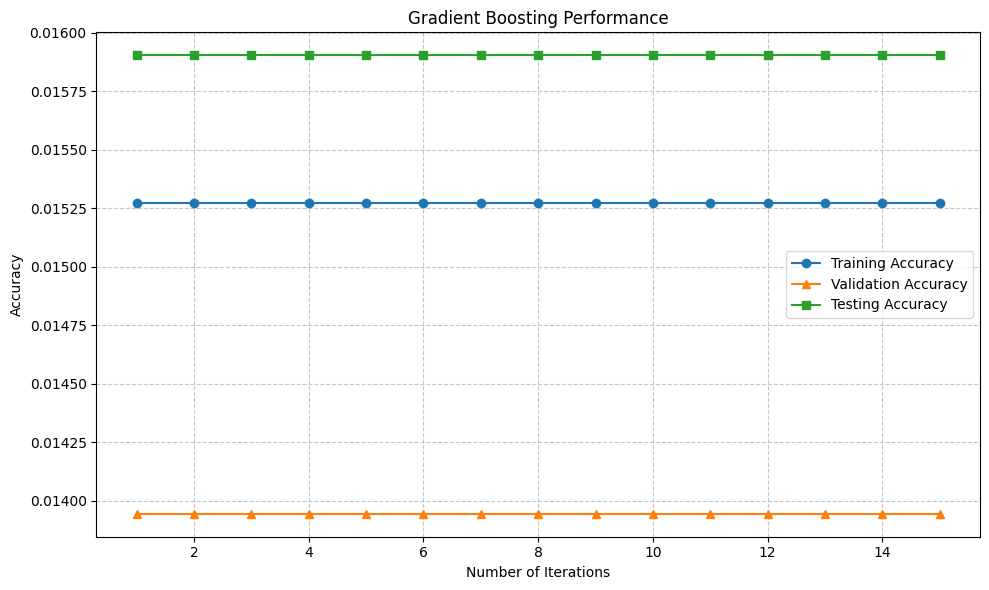


Testing Gradient Boosting with max_depth = 2

Testing Gradient Boosting on Decision Trees...
Gradient Boosting with 1 iterations - Train Accuracy: 0.0153, Validation Accuracy: 0.0139, Test Accuracy: 0.0159
Gradient Boosting with 2 iterations - Train Accuracy: 0.0153, Validation Accuracy: 0.0139, Test Accuracy: 0.0159
Gradient Boosting with 3 iterations - Train Accuracy: 0.0153, Validation Accuracy: 0.0139, Test Accuracy: 0.0159
Gradient Boosting with 4 iterations - Train Accuracy: 0.0153, Validation Accuracy: 0.0139, Test Accuracy: 0.0159
Gradient Boosting with 5 iterations - Train Accuracy: 0.0153, Validation Accuracy: 0.0139, Test Accuracy: 0.0159
Gradient Boosting with 6 iterations - Train Accuracy: 0.0153, Validation Accuracy: 0.0139, Test Accuracy: 0.0159
Gradient Boosting with 7 iterations - Train Accuracy: 0.0153, Validation Accuracy: 0.0139, Test Accuracy: 0.0159
Gradient Boosting with 8 iterations - Train Accuracy: 0.0153, Validation Accuracy: 0.0139, Test Accuracy: 0.0159
Gr

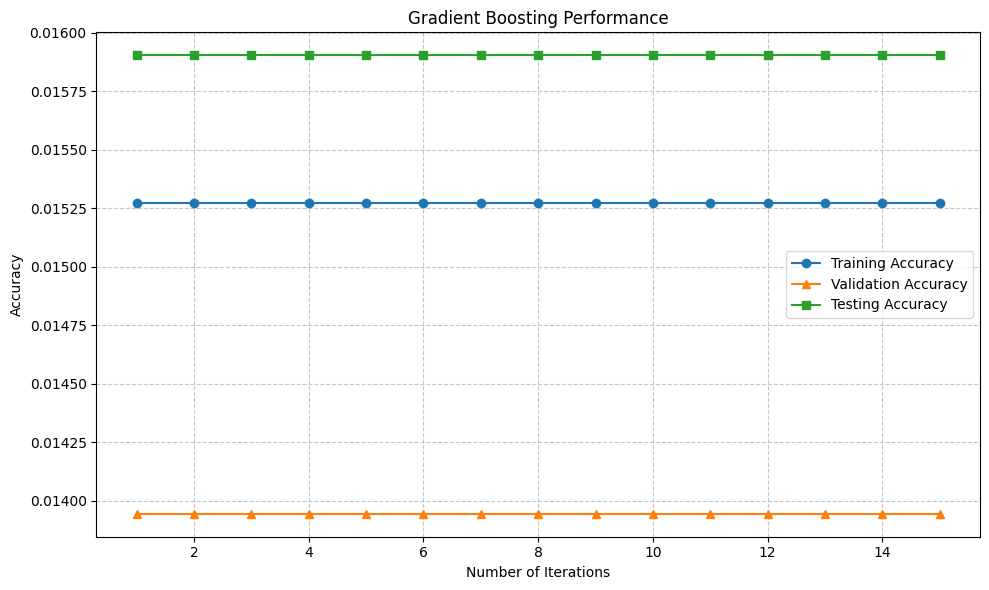


Testing Gradient Boosting with max_depth = 3

Testing Gradient Boosting on Decision Trees...
Gradient Boosting with 1 iterations - Train Accuracy: 0.1408, Validation Accuracy: 0.1255, Test Accuracy: 0.1312
Gradient Boosting with 2 iterations - Train Accuracy: 0.1401, Validation Accuracy: 0.1215, Test Accuracy: 0.1312
Gradient Boosting with 3 iterations - Train Accuracy: 0.1401, Validation Accuracy: 0.1215, Test Accuracy: 0.1272
Gradient Boosting with 4 iterations - Train Accuracy: 0.1521, Validation Accuracy: 0.1355, Test Accuracy: 0.1372
Gradient Boosting with 5 iterations - Train Accuracy: 0.1494, Validation Accuracy: 0.1295, Test Accuracy: 0.1372
Gradient Boosting with 6 iterations - Train Accuracy: 0.1487, Validation Accuracy: 0.1295, Test Accuracy: 0.1372
Gradient Boosting with 7 iterations - Train Accuracy: 0.1494, Validation Accuracy: 0.1295, Test Accuracy: 0.1372
Gradient Boosting with 8 iterations - Train Accuracy: 0.1487, Validation Accuracy: 0.1295, Test Accuracy: 0.1372
Gr

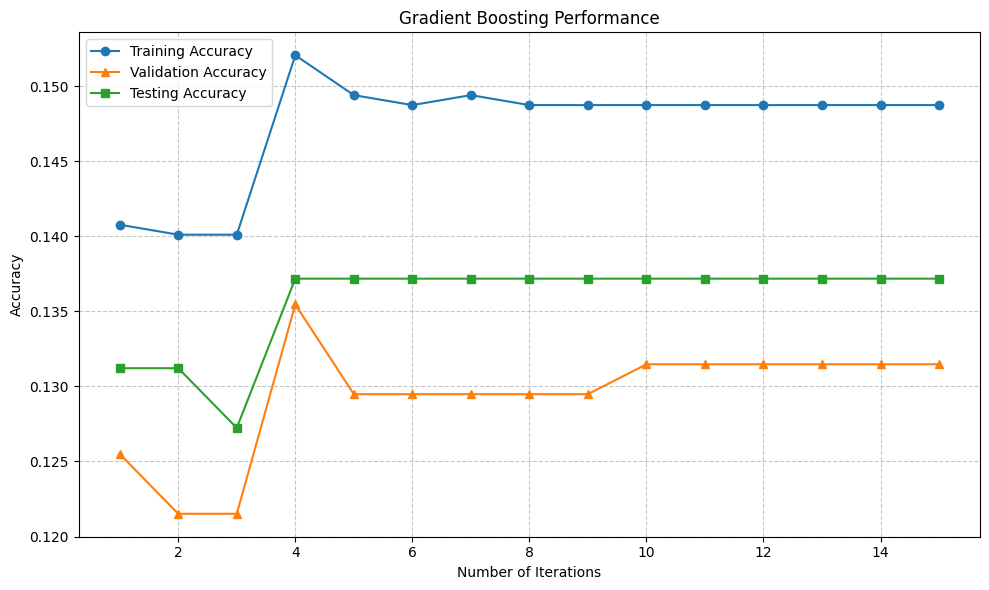


Testing Gradient Boosting with max_depth = 5

Testing Gradient Boosting on Decision Trees...
Gradient Boosting with 1 iterations - Train Accuracy: 0.7908, Validation Accuracy: 0.4801, Test Accuracy: 0.5010
Gradient Boosting with 2 iterations - Train Accuracy: 0.8506, Validation Accuracy: 0.5697, Test Accuracy: 0.5646
Gradient Boosting with 3 iterations - Train Accuracy: 0.8652, Validation Accuracy: 0.6135, Test Accuracy: 0.6024
Gradient Boosting with 4 iterations - Train Accuracy: 0.8652, Validation Accuracy: 0.6175, Test Accuracy: 0.6083
Gradient Boosting with 5 iterations - Train Accuracy: 0.8692, Validation Accuracy: 0.6056, Test Accuracy: 0.6083
Gradient Boosting with 6 iterations - Train Accuracy: 0.8659, Validation Accuracy: 0.6155, Test Accuracy: 0.6163
Gradient Boosting with 7 iterations - Train Accuracy: 0.8672, Validation Accuracy: 0.6076, Test Accuracy: 0.6143
Gradient Boosting with 8 iterations - Train Accuracy: 0.8499, Validation Accuracy: 0.5916, Test Accuracy: 0.6223
Gr

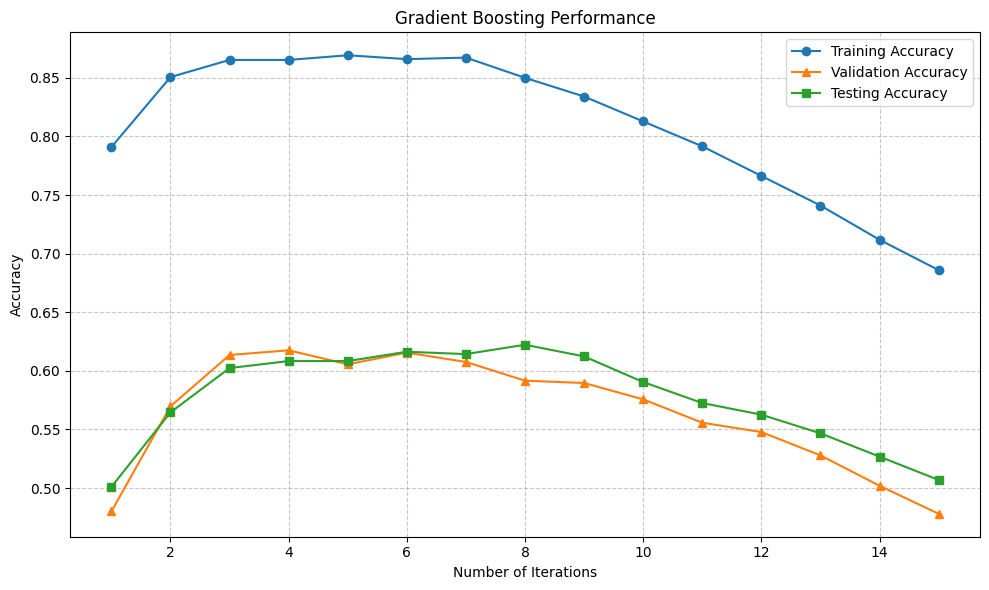


Testing Gradient Boosting with max_depth = 7

Testing Gradient Boosting on Decision Trees...
Gradient Boosting with 1 iterations - Train Accuracy: 0.9635, Validation Accuracy: 0.5359, Test Accuracy: 0.5487
Gradient Boosting with 2 iterations - Train Accuracy: 0.9834, Validation Accuracy: 0.6375, Test Accuracy: 0.6342
Gradient Boosting with 3 iterations - Train Accuracy: 0.9867, Validation Accuracy: 0.6594, Test Accuracy: 0.6740
Gradient Boosting with 4 iterations - Train Accuracy: 0.9887, Validation Accuracy: 0.6514, Test Accuracy: 0.6958
Gradient Boosting with 5 iterations - Train Accuracy: 0.9934, Validation Accuracy: 0.6713, Test Accuracy: 0.7097
Gradient Boosting with 6 iterations - Train Accuracy: 0.9947, Validation Accuracy: 0.6853, Test Accuracy: 0.7157
Gradient Boosting with 7 iterations - Train Accuracy: 0.9954, Validation Accuracy: 0.6713, Test Accuracy: 0.7157
Gradient Boosting with 8 iterations - Train Accuracy: 0.9960, Validation Accuracy: 0.6454, Test Accuracy: 0.6998
Gr

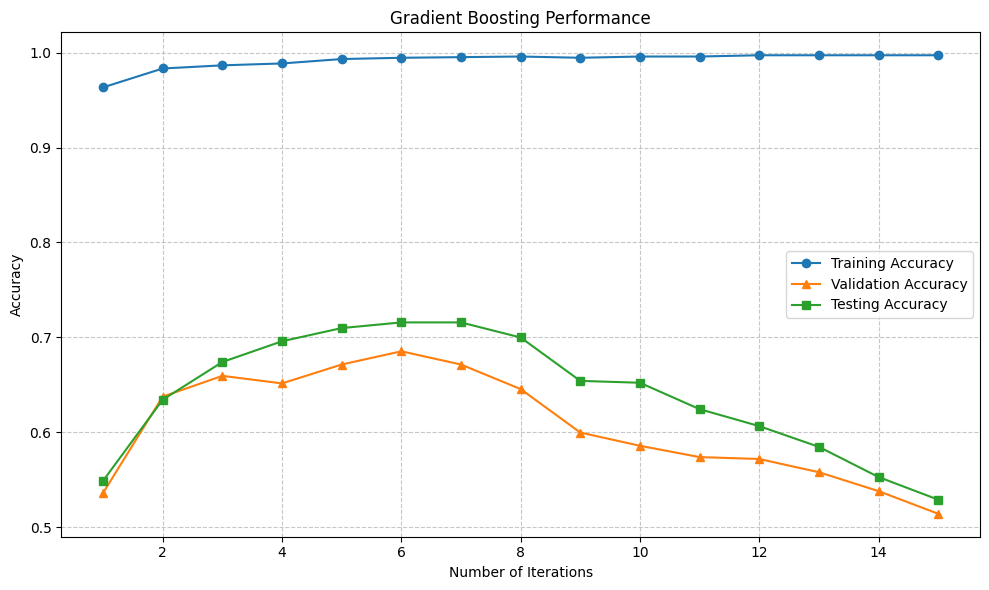

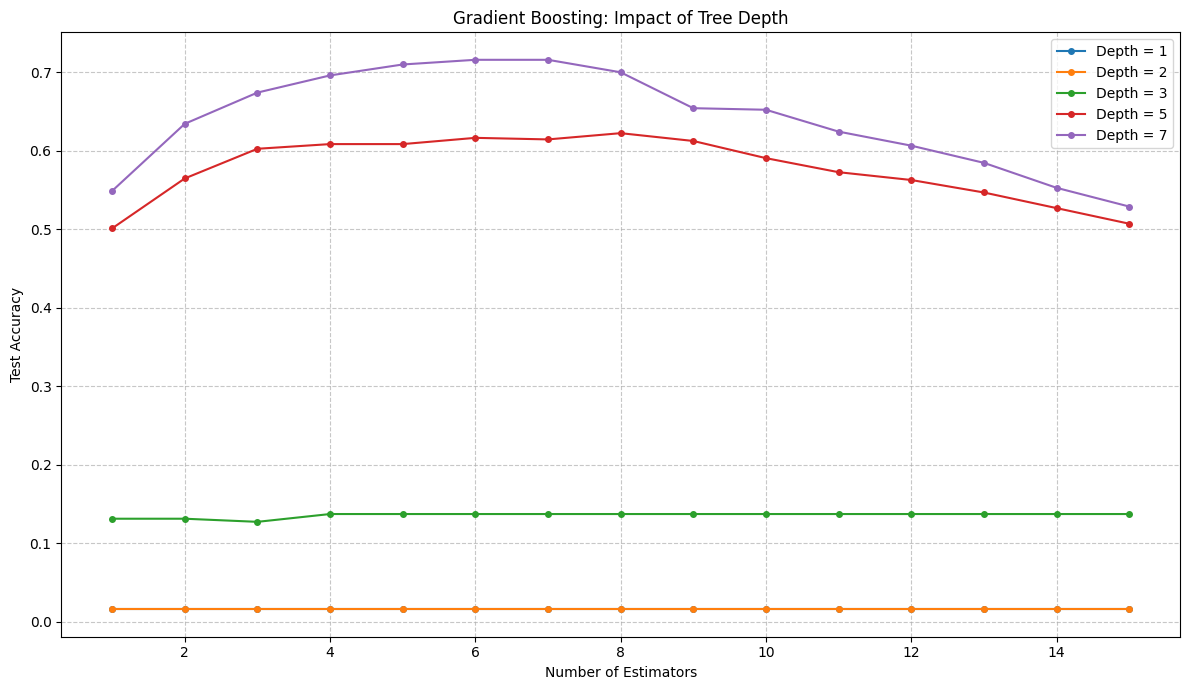


Best Gradient Boosting Tree Depth: 7 with accuracy 0.5288

--- Stacked Ensemble (RF) Tree Depth Experiment ---

Testing Stacked Ensemble with RF max_depth = 3

Training Stacked Ensemble (SVM + GMM + Random Forest)...

Training base learners...
Training SVM...
Training GMM...
Training Random Forest...

Generating meta-features...

Training meta-learner...
Stacked Ensemble with 1 RF trees - Train accuracy: 0.1853, Val accuracy: 0.1952, Test accuracy: 0.1630
Stacked Ensemble with 2 RF trees - Train accuracy: 0.1853, Val accuracy: 0.1952, Test accuracy: 0.1630
Stacked Ensemble with 3 RF trees - Train accuracy: 0.1760, Val accuracy: 0.1892, Test accuracy: 0.1630
Stacked Ensemble with 4 RF trees - Train accuracy: 0.1813, Val accuracy: 0.1992, Test accuracy: 0.1710
Stacked Ensemble with 5 RF trees - Train accuracy: 0.1912, Val accuracy: 0.2191, Test accuracy: 0.1928
Stacked Ensemble with 6 RF trees - Train accuracy: 0.1839, Val accuracy: 0.2151, Test accuracy: 0.1889
Stacked Ensemble with 7 

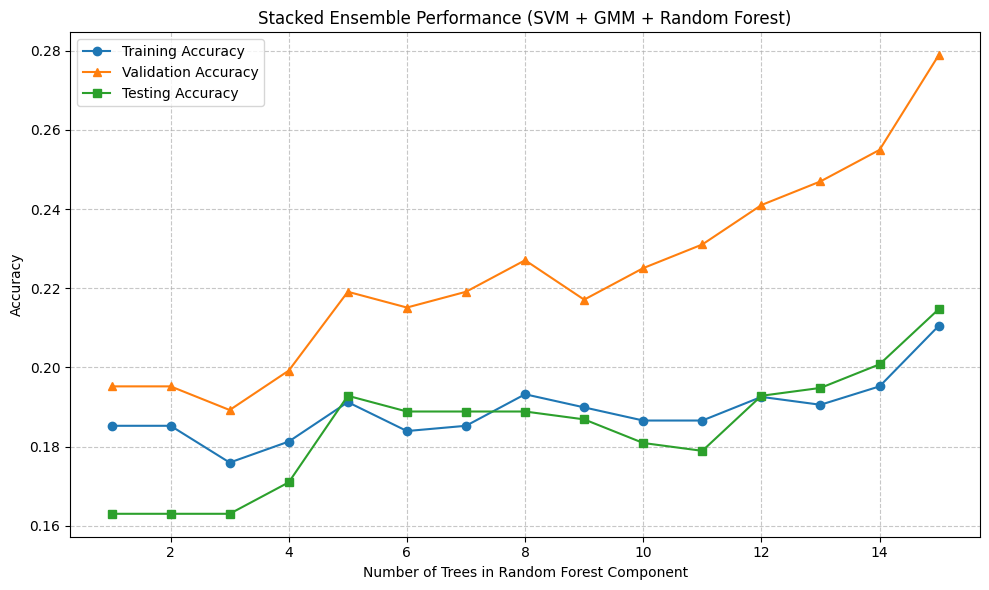

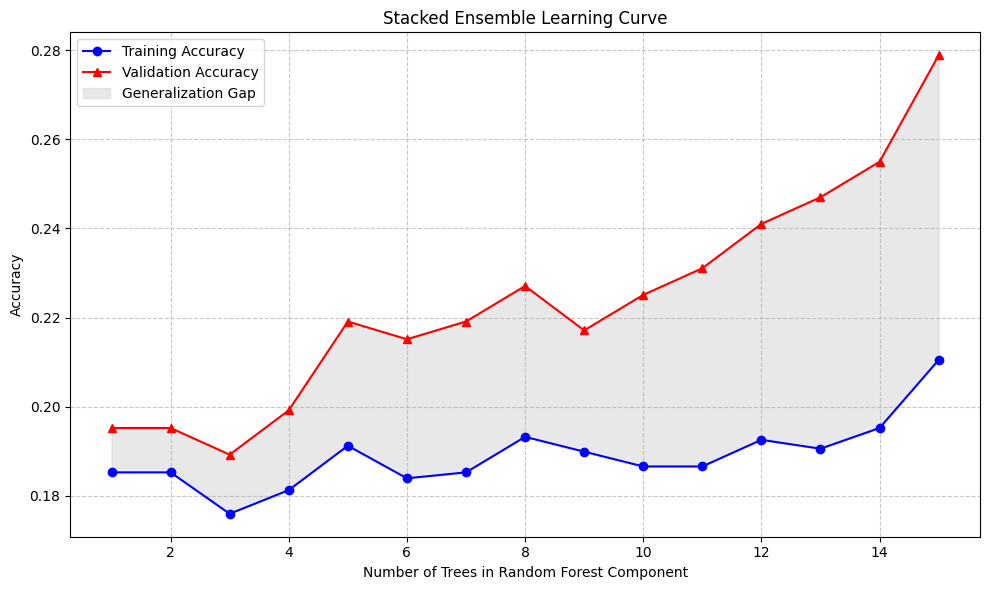


Testing Stacked Ensemble with RF max_depth = 5

Training Stacked Ensemble (SVM + GMM + Random Forest)...

Training base learners...
Training SVM...
Training GMM...
Training Random Forest...

Generating meta-features...

Training meta-learner...
Stacked Ensemble with 1 RF trees - Train accuracy: 0.2590, Val accuracy: 0.1753, Test accuracy: 0.1869
Stacked Ensemble with 2 RF trees - Train accuracy: 0.2590, Val accuracy: 0.1753, Test accuracy: 0.1869
Stacked Ensemble with 3 RF trees - Train accuracy: 0.3287, Val accuracy: 0.1972, Test accuracy: 0.2147
Stacked Ensemble with 4 RF trees - Train accuracy: 0.3652, Val accuracy: 0.2191, Test accuracy: 0.2485
Stacked Ensemble with 5 RF trees - Train accuracy: 0.4482, Val accuracy: 0.2729, Test accuracy: 0.3062
Stacked Ensemble with 6 RF trees - Train accuracy: 0.4993, Val accuracy: 0.3247, Test accuracy: 0.3400
Stacked Ensemble with 7 RF trees - Train accuracy: 0.5232, Val accuracy: 0.3645, Test accuracy: 0.3618
Stacked Ensemble with 8 RF trees 

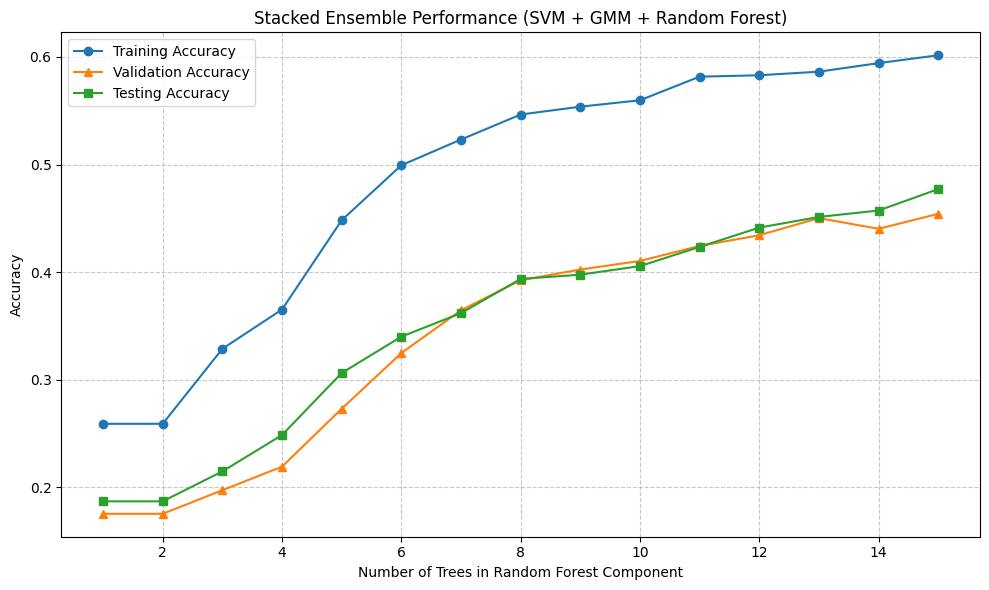

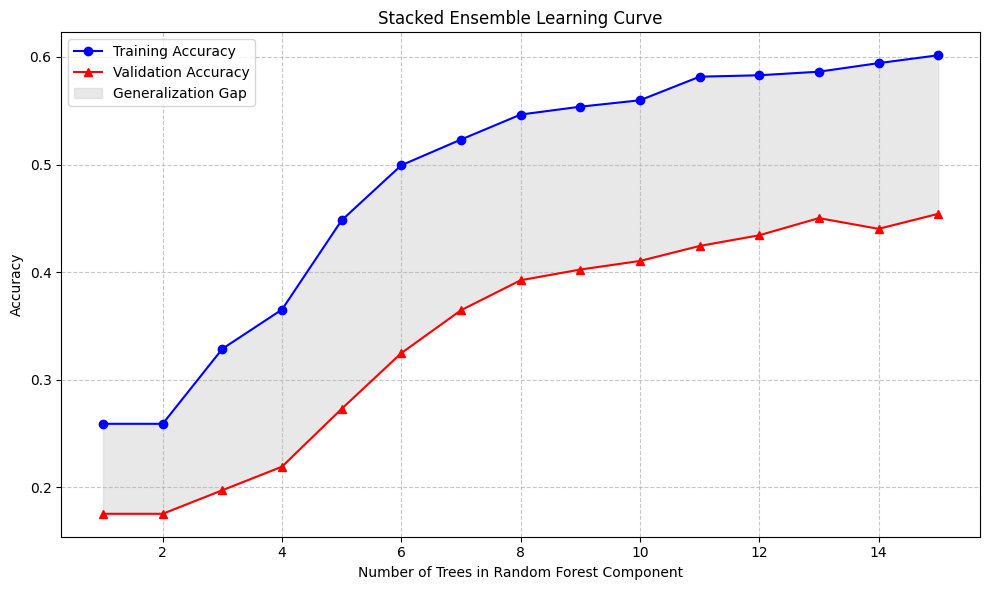


Testing Stacked Ensemble with RF max_depth = 7

Training Stacked Ensemble (SVM + GMM + Random Forest)...

Training base learners...
Training SVM...
Training GMM...
Training Random Forest...

Generating meta-features...

Training meta-learner...
Stacked Ensemble with 1 RF trees - Train accuracy: 0.4920, Val accuracy: 0.2908, Test accuracy: 0.3121
Stacked Ensemble with 2 RF trees - Train accuracy: 0.4920, Val accuracy: 0.2908, Test accuracy: 0.3121
Stacked Ensemble with 3 RF trees - Train accuracy: 0.5637, Val accuracy: 0.3287, Test accuracy: 0.3459
Stacked Ensemble with 4 RF trees - Train accuracy: 0.6135, Val accuracy: 0.3685, Test accuracy: 0.4036
Stacked Ensemble with 5 RF trees - Train accuracy: 0.6421, Val accuracy: 0.3924, Test accuracy: 0.4254
Stacked Ensemble with 6 RF trees - Train accuracy: 0.6580, Val accuracy: 0.4203, Test accuracy: 0.4573
Stacked Ensemble with 7 RF trees - Train accuracy: 0.6667, Val accuracy: 0.4422, Test accuracy: 0.4751
Stacked Ensemble with 8 RF trees 

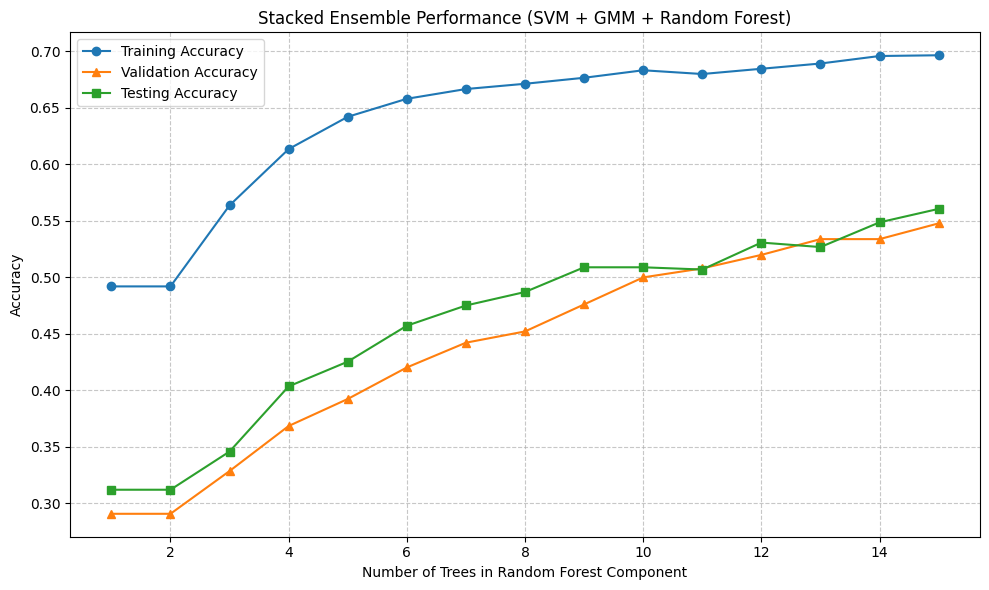

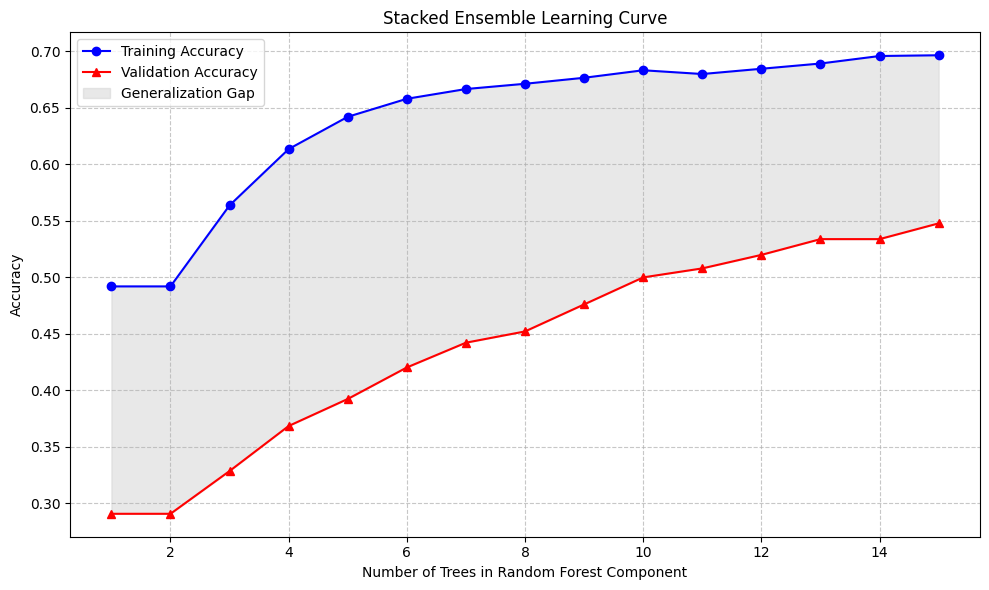


Testing Stacked Ensemble with RF max_depth = None (unlimited)

Training Stacked Ensemble (SVM + GMM + Random Forest)...

Training base learners...
Training SVM...
Training GMM...
Training Random Forest...

Generating meta-features...

Training meta-learner...
Stacked Ensemble with 1 RF trees - Train accuracy: 0.5963, Val accuracy: 0.2809, Test accuracy: 0.2783
Stacked Ensemble with 2 RF trees - Train accuracy: 0.5963, Val accuracy: 0.2809, Test accuracy: 0.2783
Stacked Ensemble with 3 RF trees - Train accuracy: 0.6886, Val accuracy: 0.3207, Test accuracy: 0.3141
Stacked Ensemble with 4 RF trees - Train accuracy: 0.7078, Val accuracy: 0.3625, Test accuracy: 0.3817
Stacked Ensemble with 5 RF trees - Train accuracy: 0.7205, Val accuracy: 0.4024, Test accuracy: 0.4115
Stacked Ensemble with 6 RF trees - Train accuracy: 0.7258, Val accuracy: 0.4243, Test accuracy: 0.4314
Stacked Ensemble with 7 RF trees - Train accuracy: 0.7264, Val accuracy: 0.4701, Test accuracy: 0.4990
Stacked Ensemble w

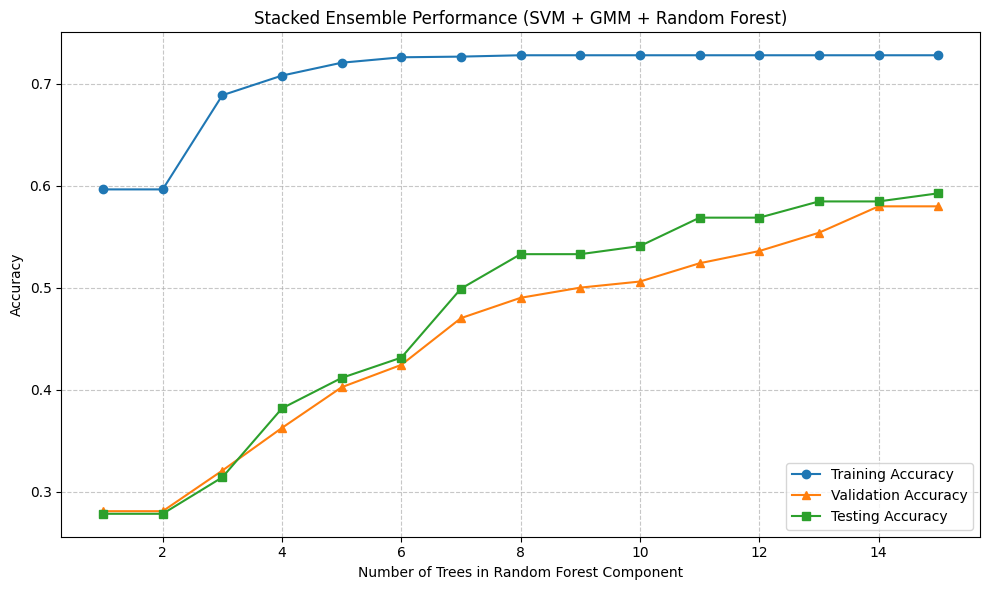

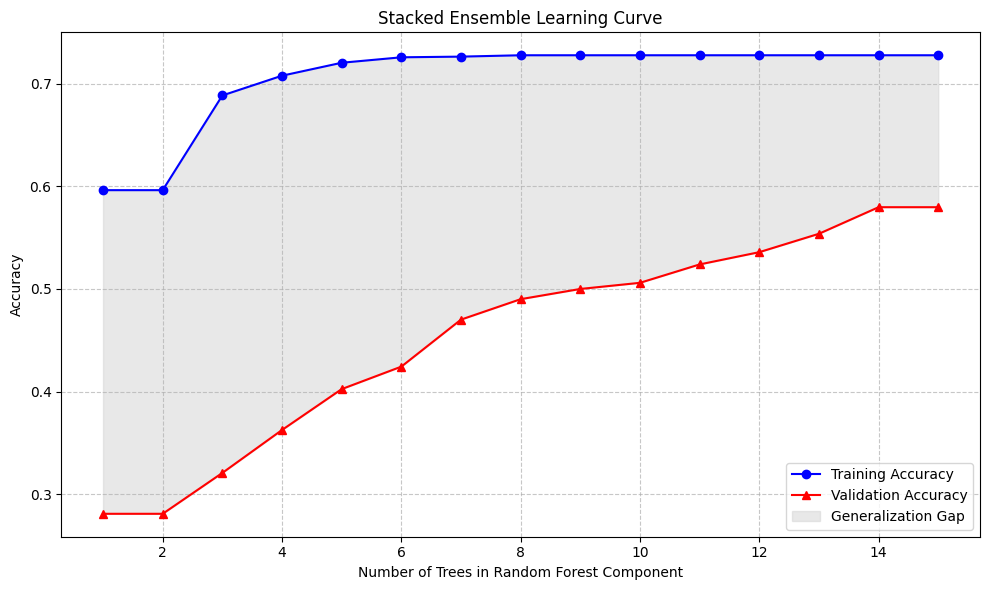

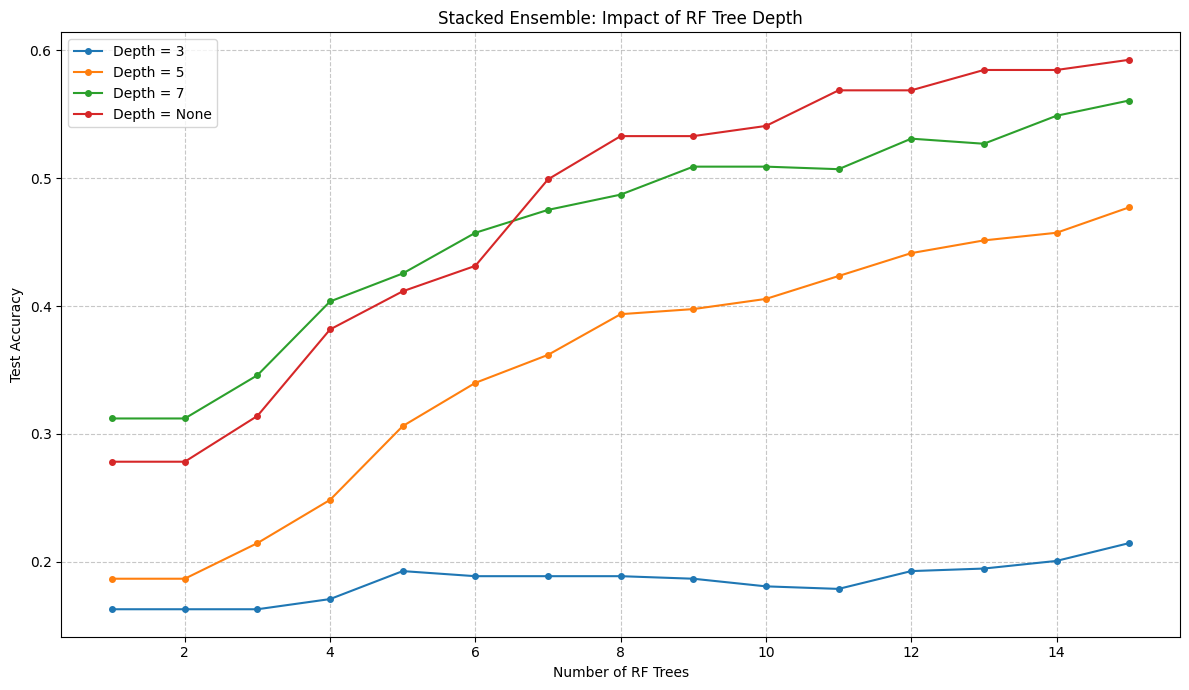


Best Stacked Ensemble RF Tree Depth: None (unlimited) with accuracy 0.5924


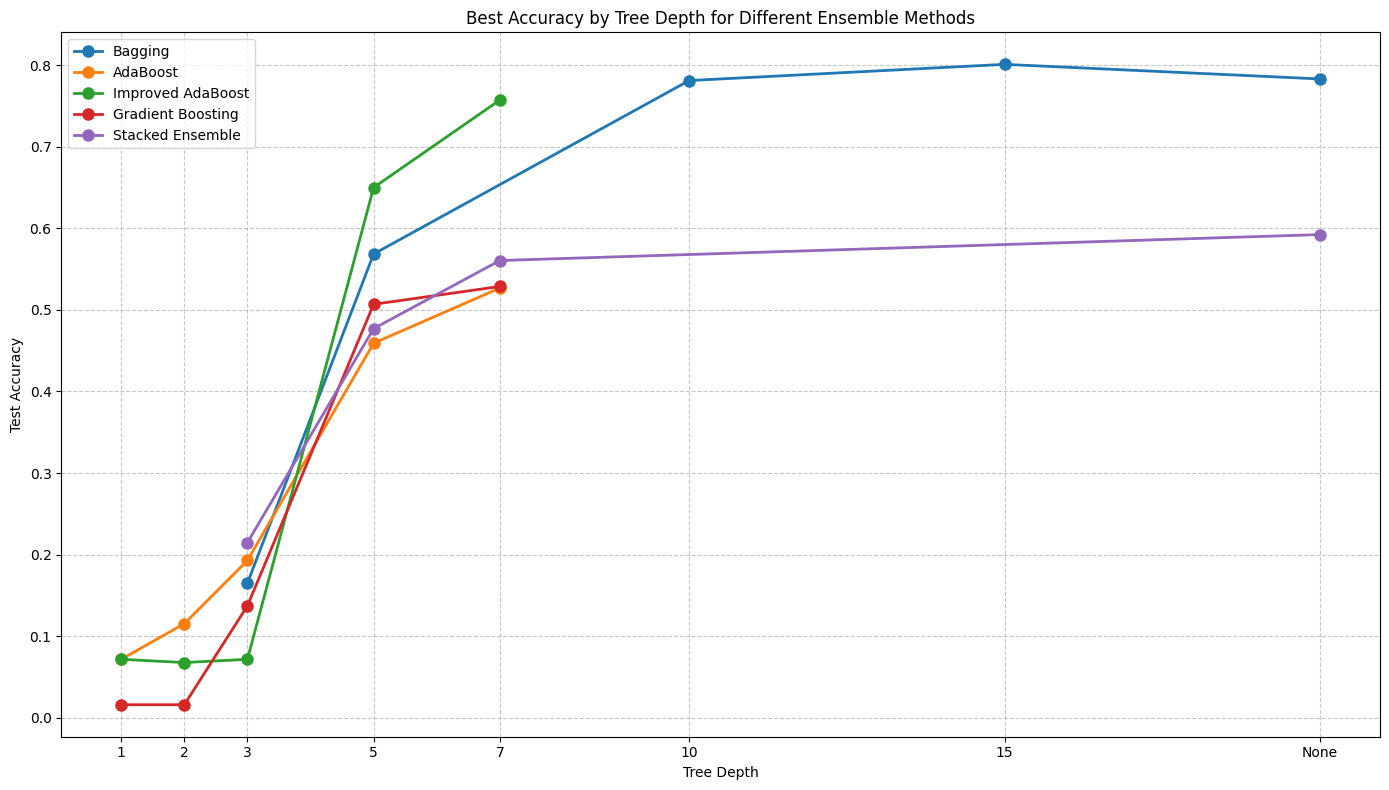


--- Best Tree Depths Summary ---
Bagging: Best depth = 15, Accuracy = 0.8012
AdaBoost: Best depth = 7, Accuracy = 0.5268
Improved AdaBoost: Best depth = 7, Accuracy = 0.7575
Gradient Boosting: Best depth = 7, Accuracy = 0.5288
Stacked Ensemble: Best depth = None (unlimited), Accuracy = 0.5924


In [ ]:
# Run the tree depth experiments using reduced feature sets for efficiency
print("\n\n===== TREE DEPTH EXPERIMENTS =====")
# You can uncomment the following line to run all experiments
results_dict = run_tree_depth_experiments(X_train_enhanced, y_train, X_val_enhanced, y_val, X_test_enhanced, y_test, n_estimators=15)

# Or run individual experiments as needed
# bagging_results = experiment_bagging_tree_depth(X_train_enhanced, y_train, X_val_enhanced, y_val, X_test_enhanced, y_test, n_estimators=15)
